In [194]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


Importing Libraries

In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
from sklearn.neighbors import LocalOutlierFactor

Loading Data

In [196]:
df = pd.read_pickle('D:\Projects\AI Fitness Tracker\Pre processed data\data_resampled.pkl')

viewing data


In [197]:
df

acc_x     acc_y     acc_z   gyr_x   gyr_y   gyr_z  \
epoch (ms)                                                                      
2019-01-11 15:08:05.200  0.013500  0.977000 -0.071000 -1.8904  2.4392  0.9388   
2019-01-11 15:08:05.400 -0.001500  0.970500 -0.079500 -1.6826 -0.8904  2.1708   
2019-01-11 15:08:05.600  0.001333  0.971667 -0.064333  2.5608 -0.2560 -1.4146   
2019-01-11 15:08:05.800 -0.024000  0.957000 -0.073500  8.0610 -4.5244 -2.0730   
2019-01-11 15:08:06.000 -0.028000  0.957667 -0.115000  2.4390 -1.5486 -3.6098   
...                           ...       ...       ...     ...     ...     ...   
2019-01-20 17:33:27.000 -0.048000 -1.041500 -0.076500  1.4146 -5.6218  0.2926   
2019-01-20 17:33:27.200 -0.037000 -1.030333 -0.053333 -2.7684 -0.5854  2.2440   
2019-01-20 17:33:27.400 -0.060000 -1.031000 -0.082000  2.8416 -5.1342 -0.1220   
2019-01-20 17:33:27.600 -0.038667 -1.025667 -0.044667 -0.2318  0.2562  1.1220   
2019-01-20 17:33:27.800 -0.044000 -1.034000 -0.059000  1.0980 -4.0240  0.9760   

                        participant  label category  set  
epoch (ms)                                                
2019-01-11 15:08:05.200           B  bench    heavy   30  
2019-01-11 15:08:05.400           B  bench    heavy   30  
2019-01-11 15:08:05.600           B  bench    heavy   30  
2019-01-11 15:08:05.800           B  bench    heavy   30  
2019-01-11 15:08:06.000           B  bench    heavy   30  
...                             ...    ...      ...  ...  
2019-01-20 17:33:27.000           E    row   medium   90  
2019-01-20 17:33:27.200           E    row   medium   90  
2019-01-20 17:33:27.400           E    row   medium   90  
2019-01-20 17:33:27.600           E    row   medium   90  
2019-01-20 17:33:27.800           E    row   medium   90  

[9009 rows x 10 columns]

In [198]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 5)
plt.rcParams['figure.dpi'] = 100


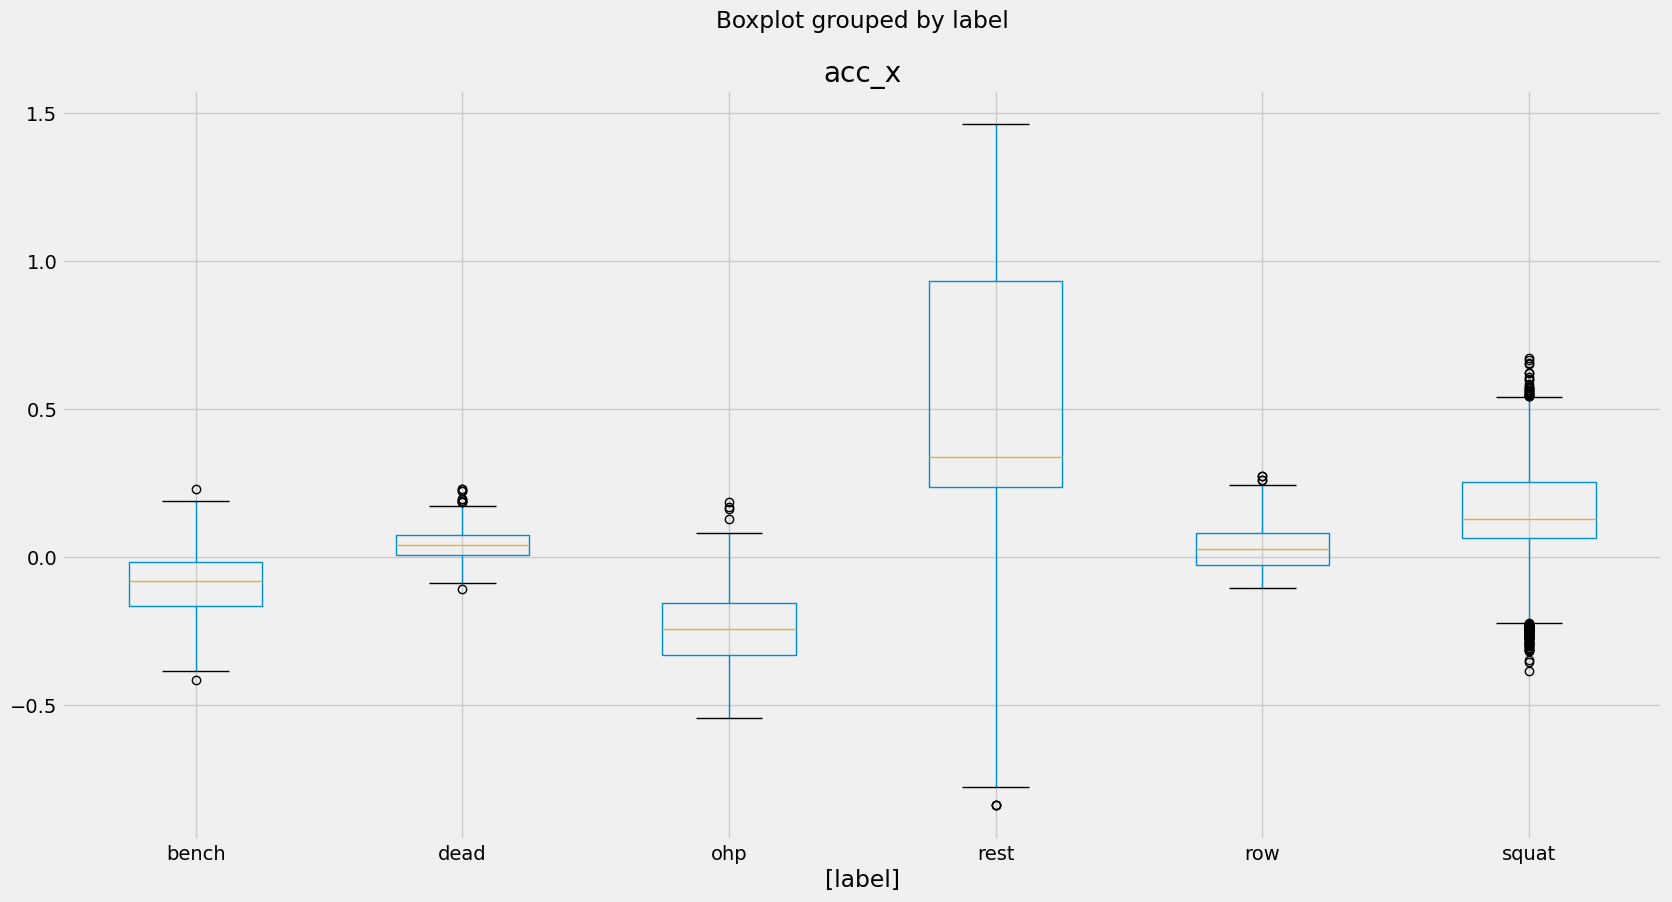

In [199]:
df[['acc_x','label']].boxplot(by = 'label',figsize=(20,10))
plt.show()

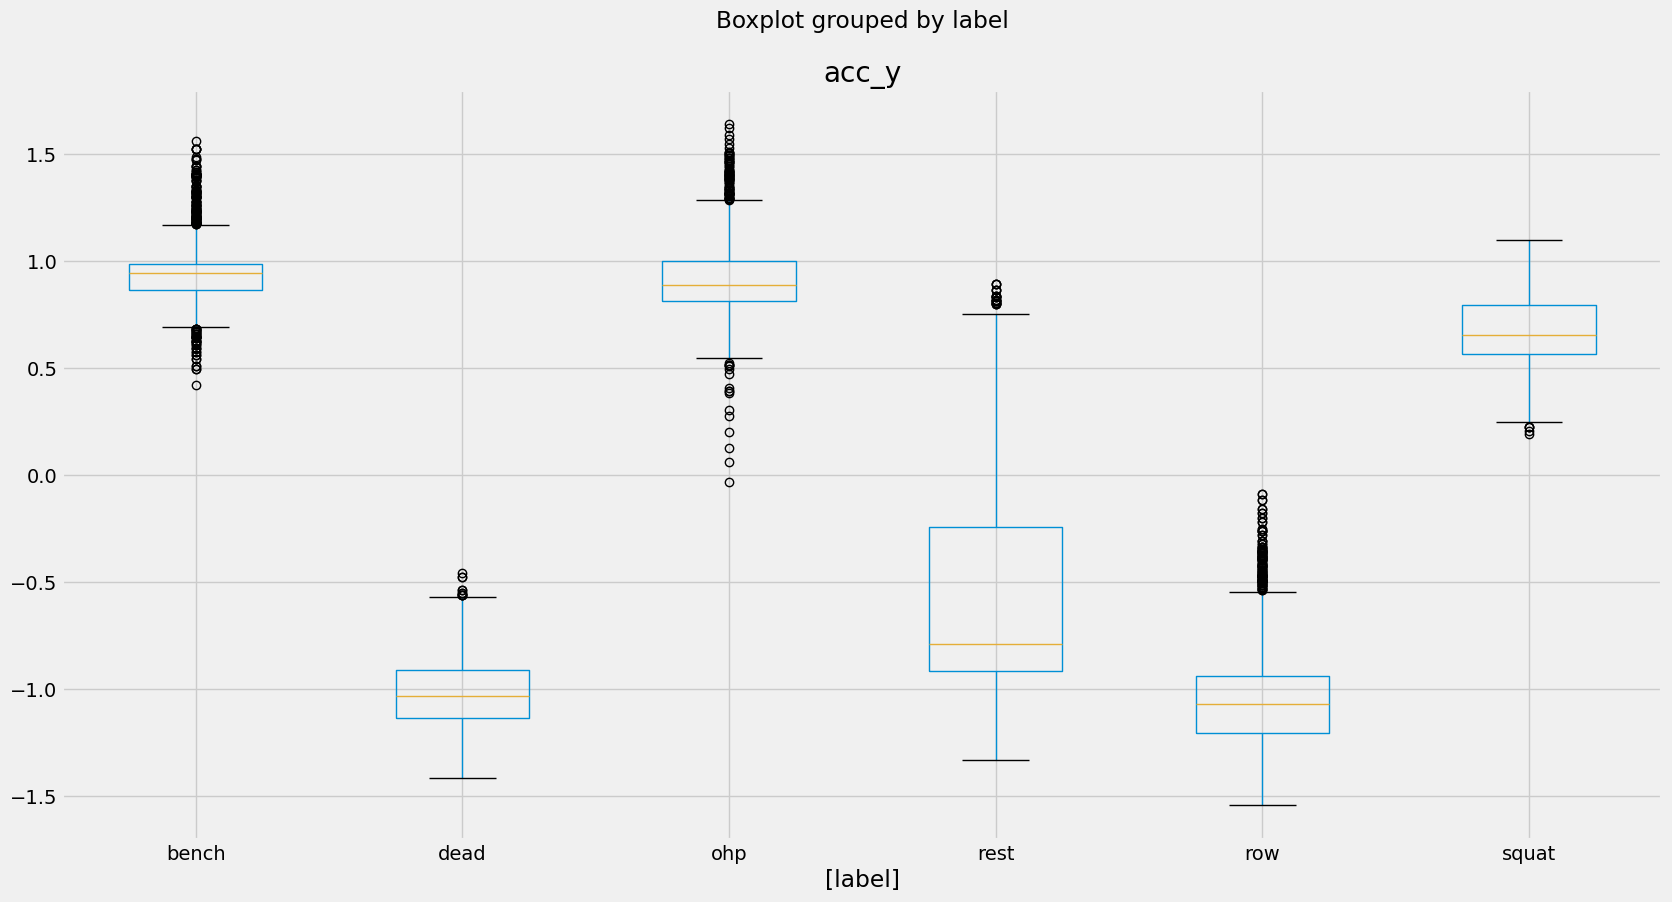

In [200]:
df[['acc_y','label']].boxplot(by = 'label',figsize=(20,10))
plt.show()

In [201]:
df.columns

Index(['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z', 'participant',
       'label', 'category', 'set'],
      dtype='object')

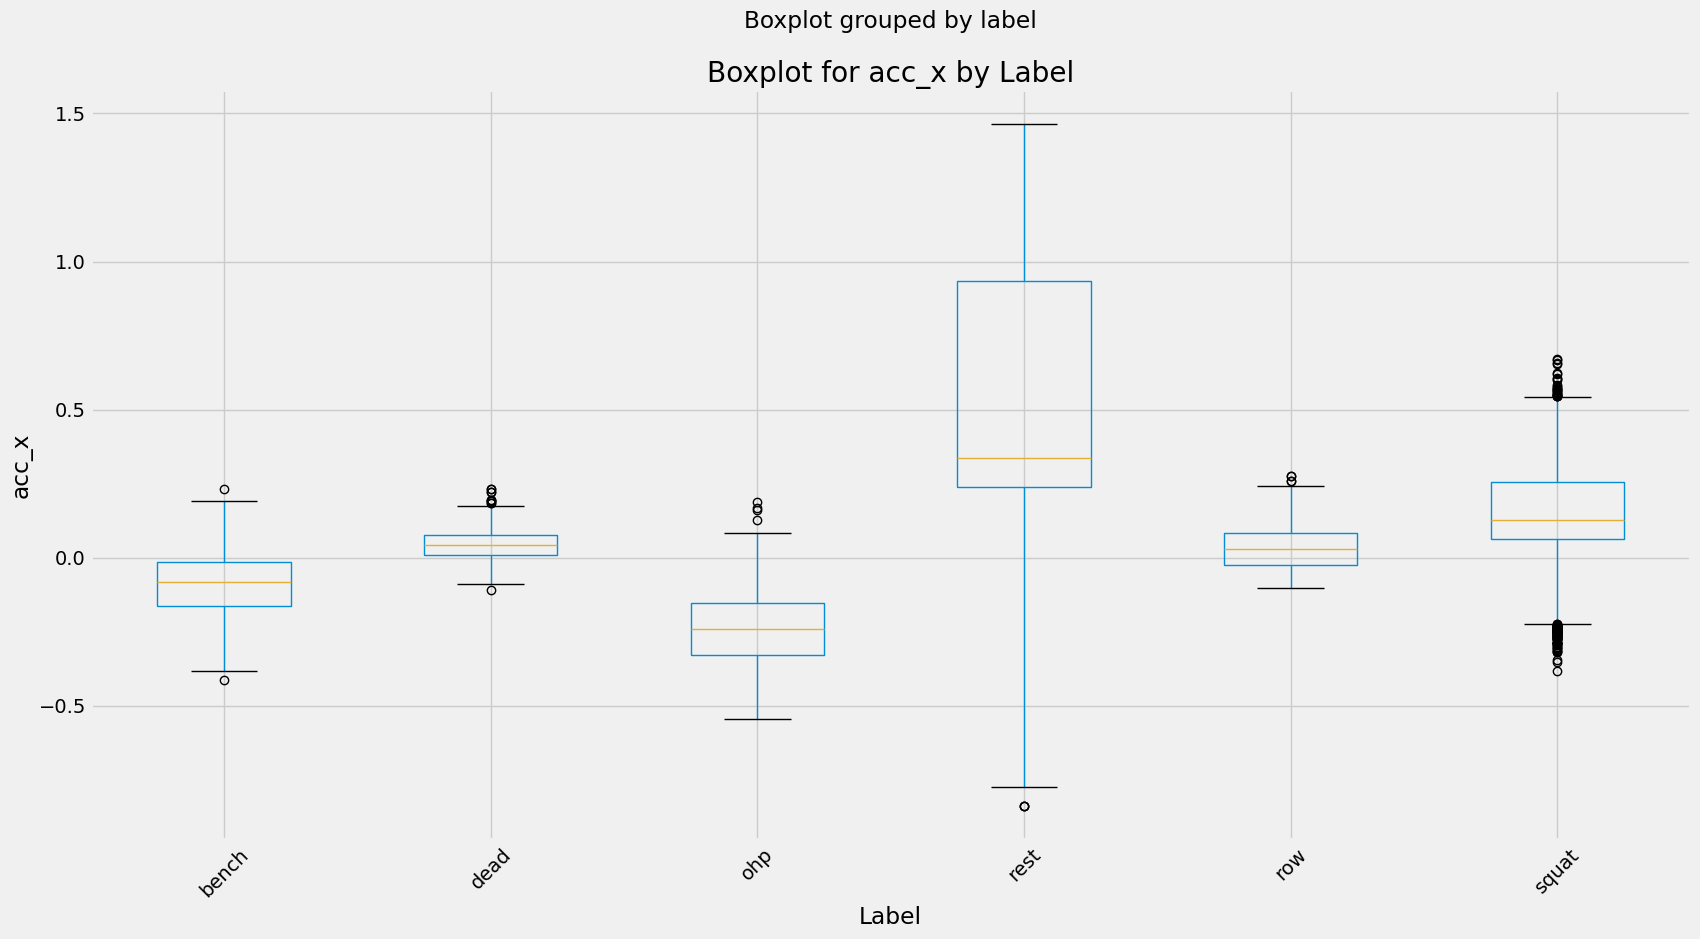

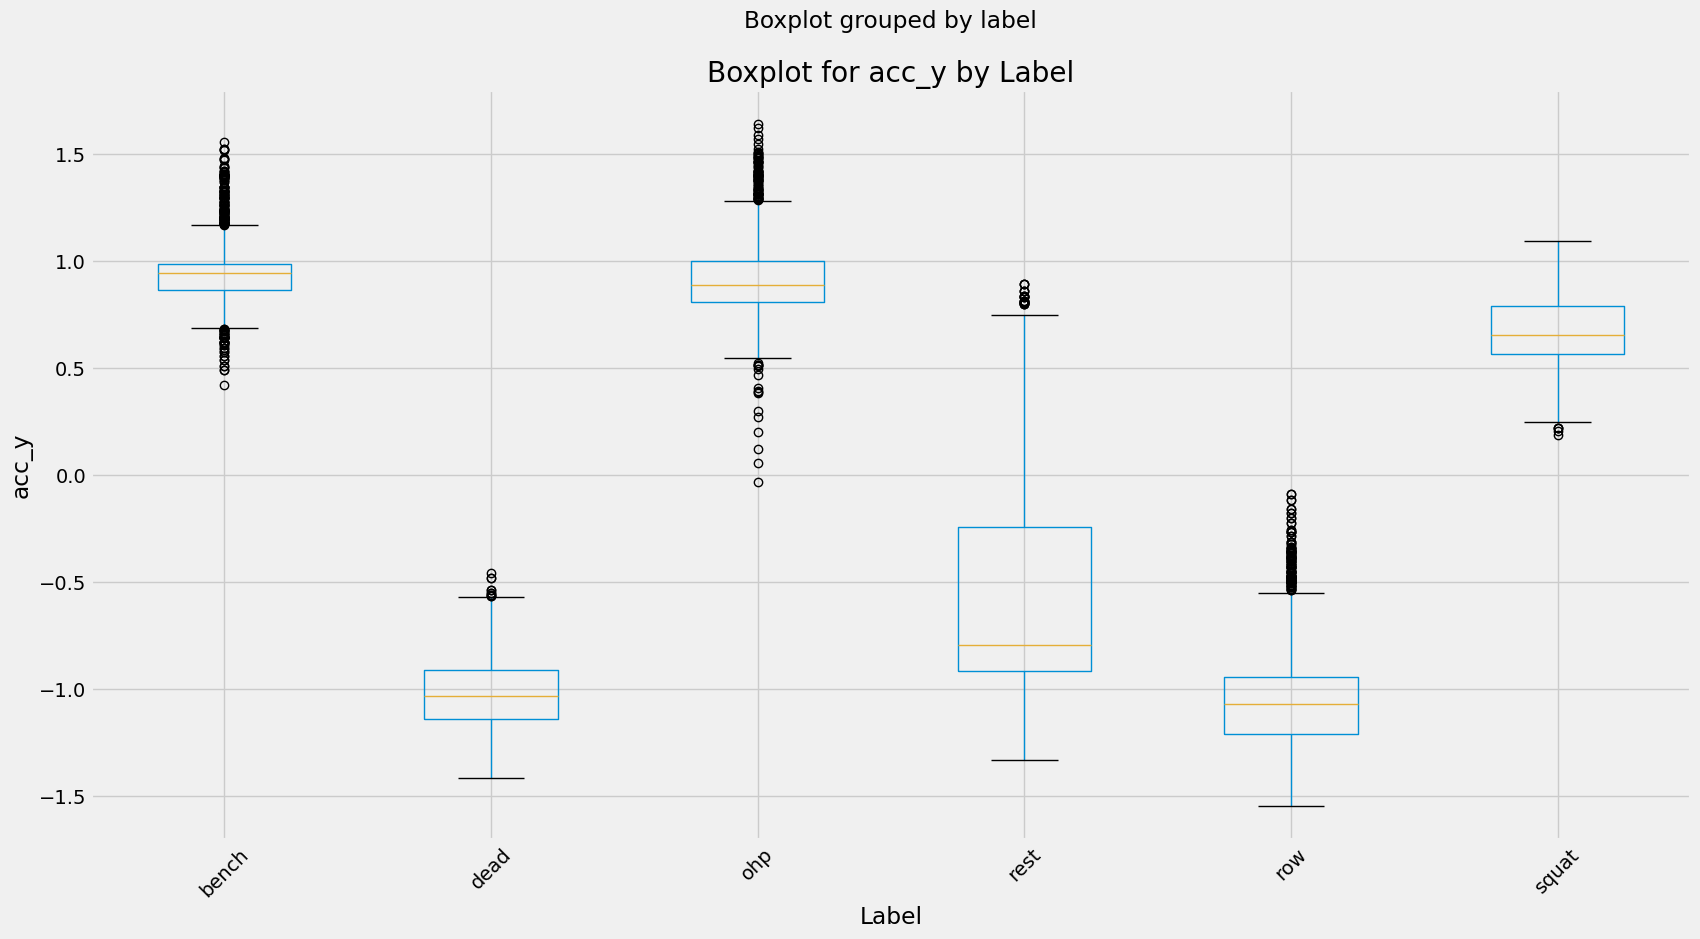

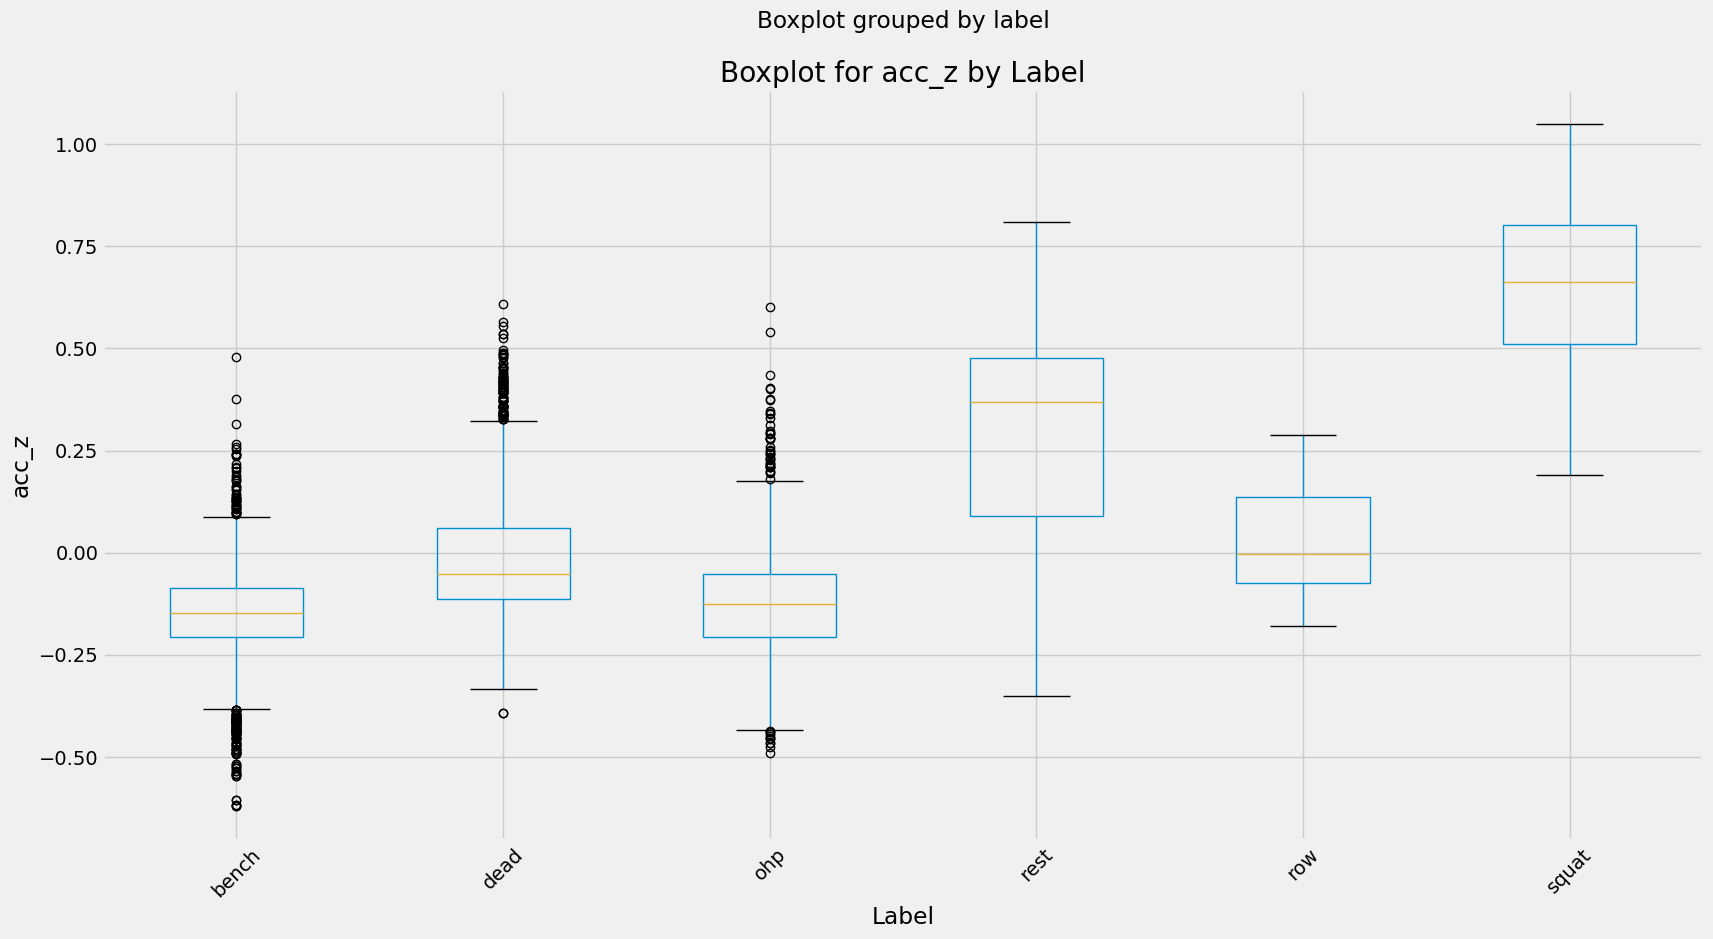

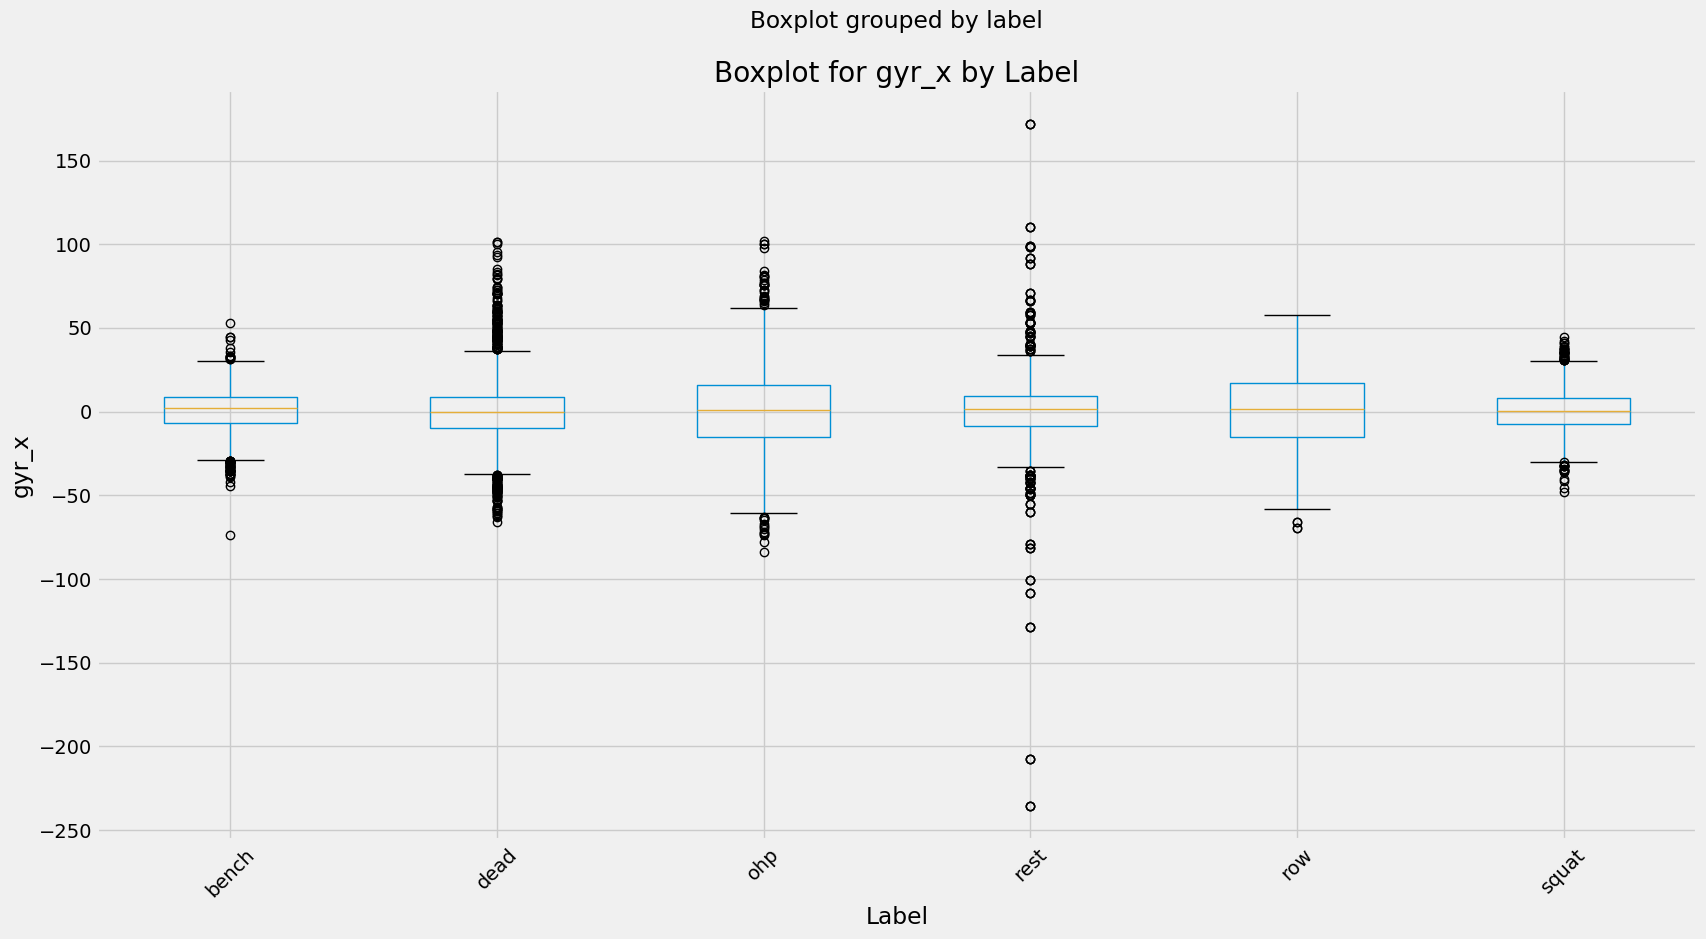

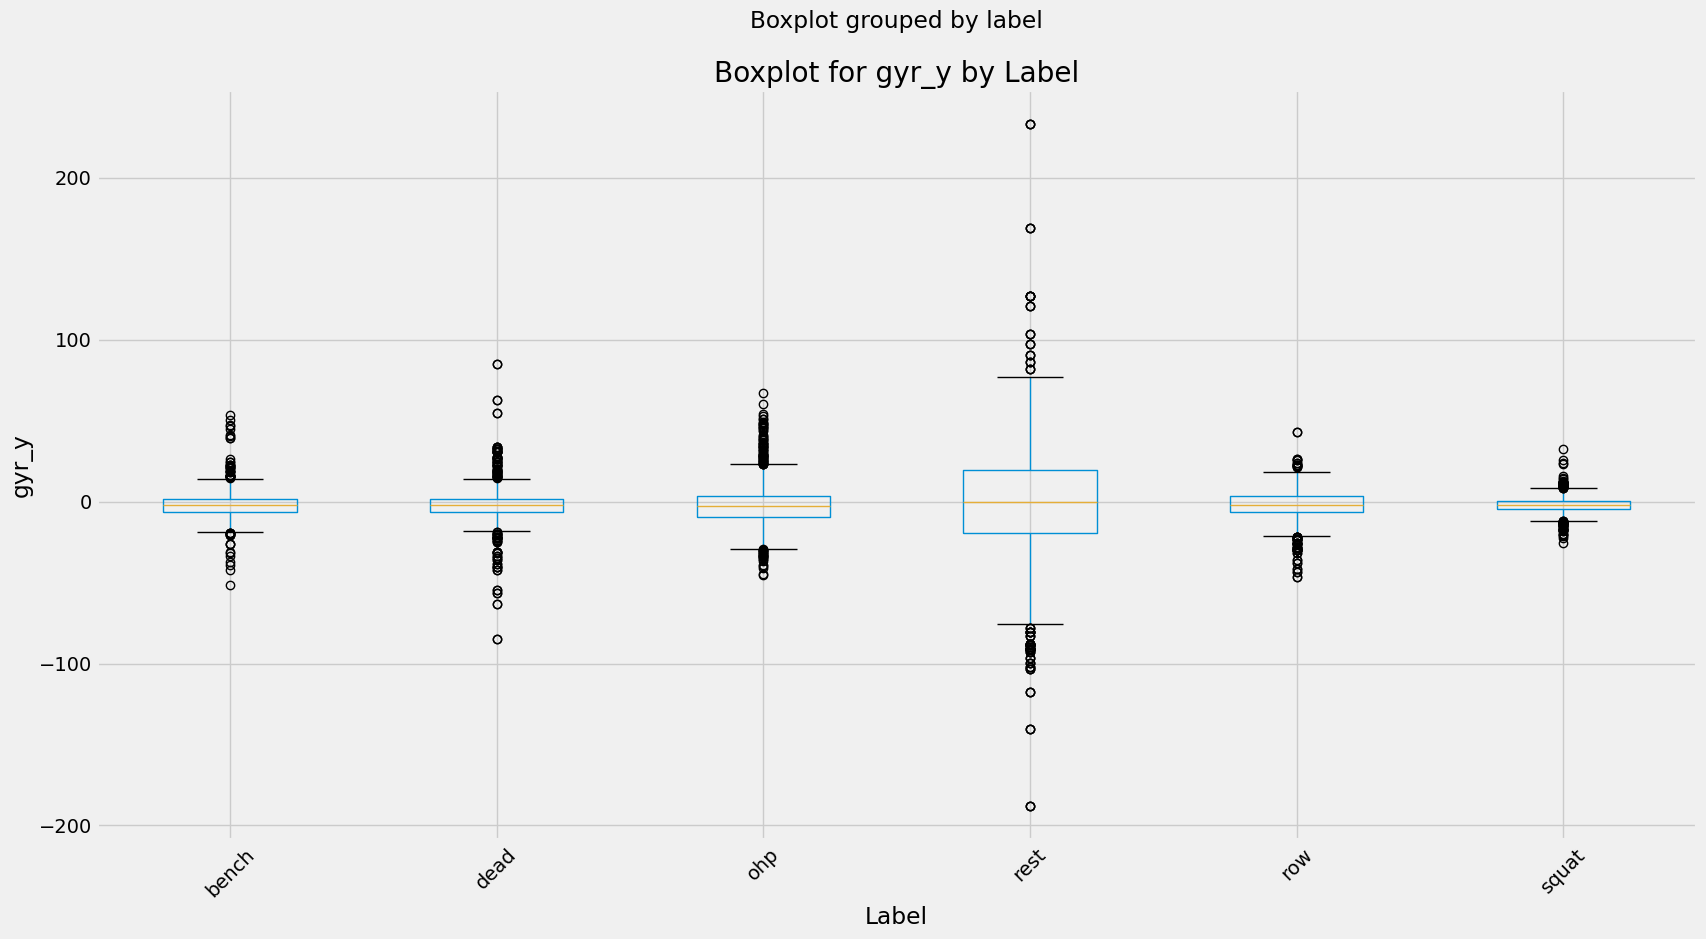

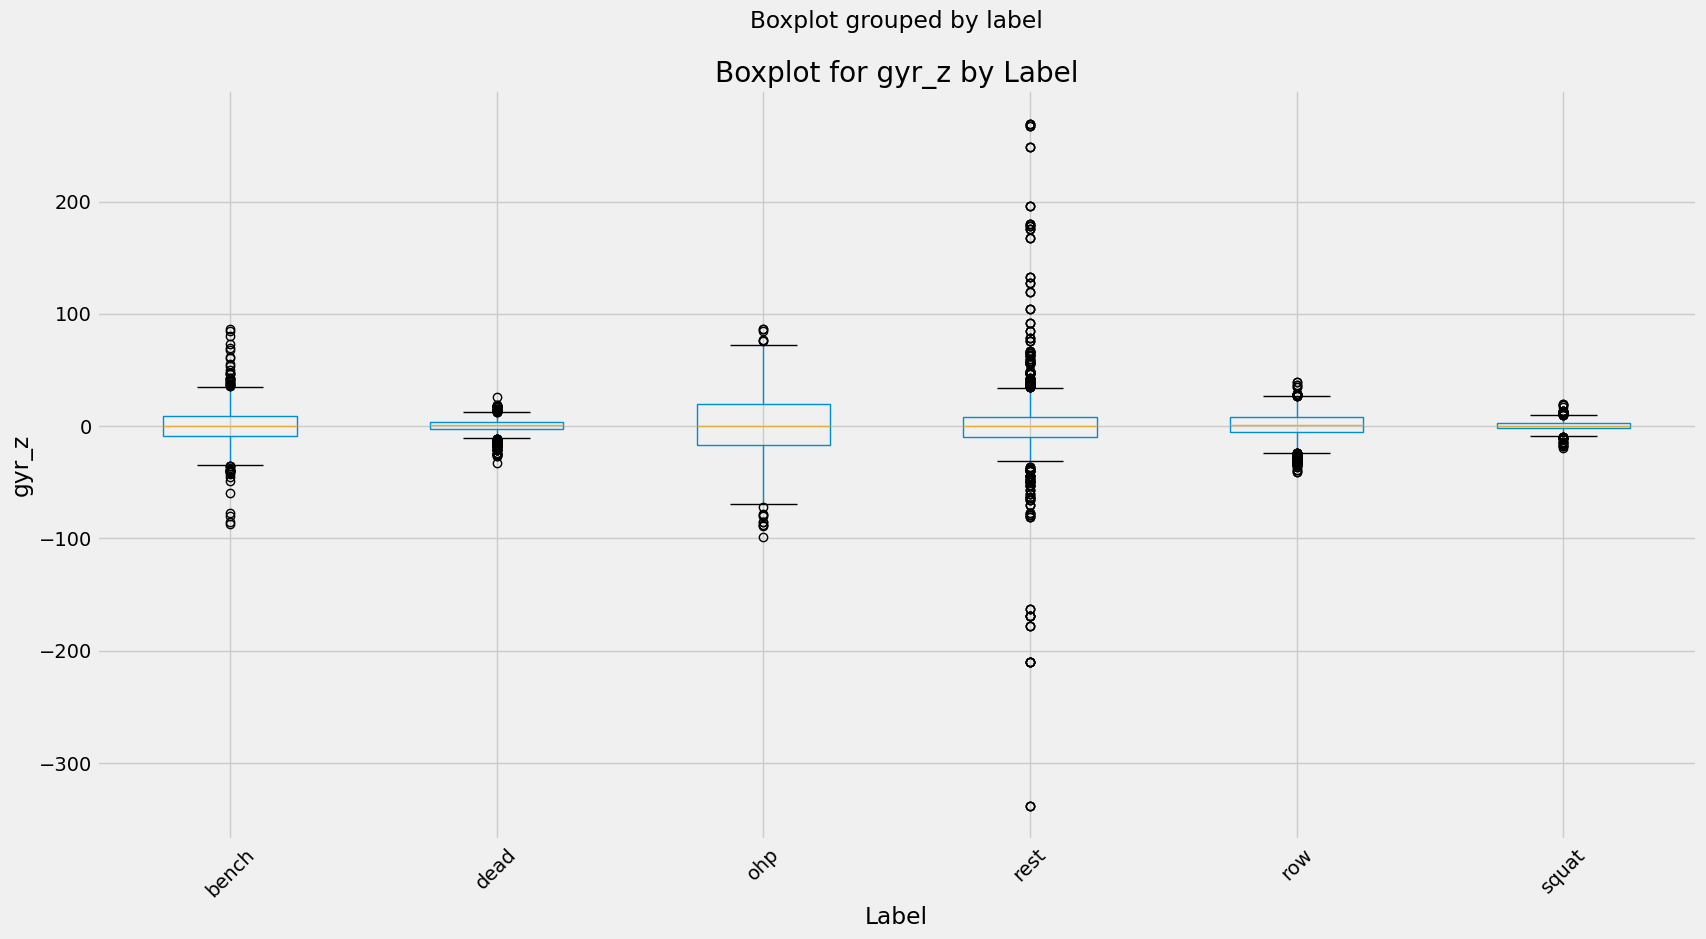

In [202]:
import matplotlib.pyplot as plt

data_label = ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']

# Iterate through each column in data_label
for column in data_label:
    # Create a boxplot for the current column, grouped by 'label'
    df.boxplot(column=column, by='label', figsize=(20, 10))
    plt.title(f'Boxplot for {column} by Label')
    plt.ylabel(column)
    plt.xlabel('Label')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()


In [203]:
outlier_column = list(df.columns[:6])

In [204]:
outlier_column

['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']

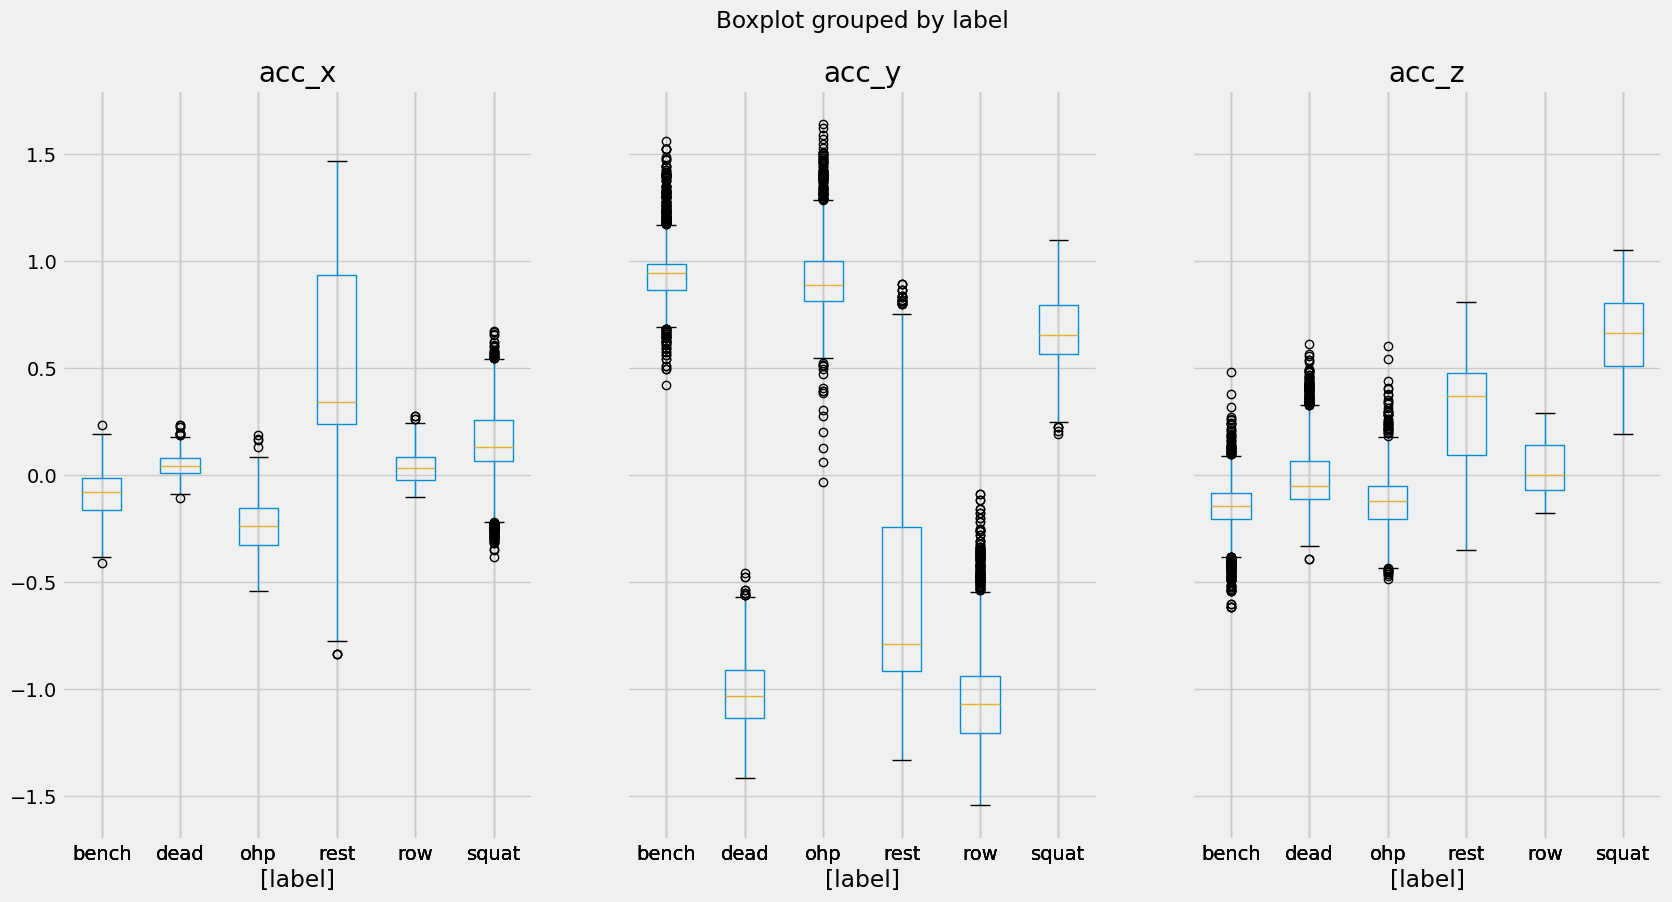

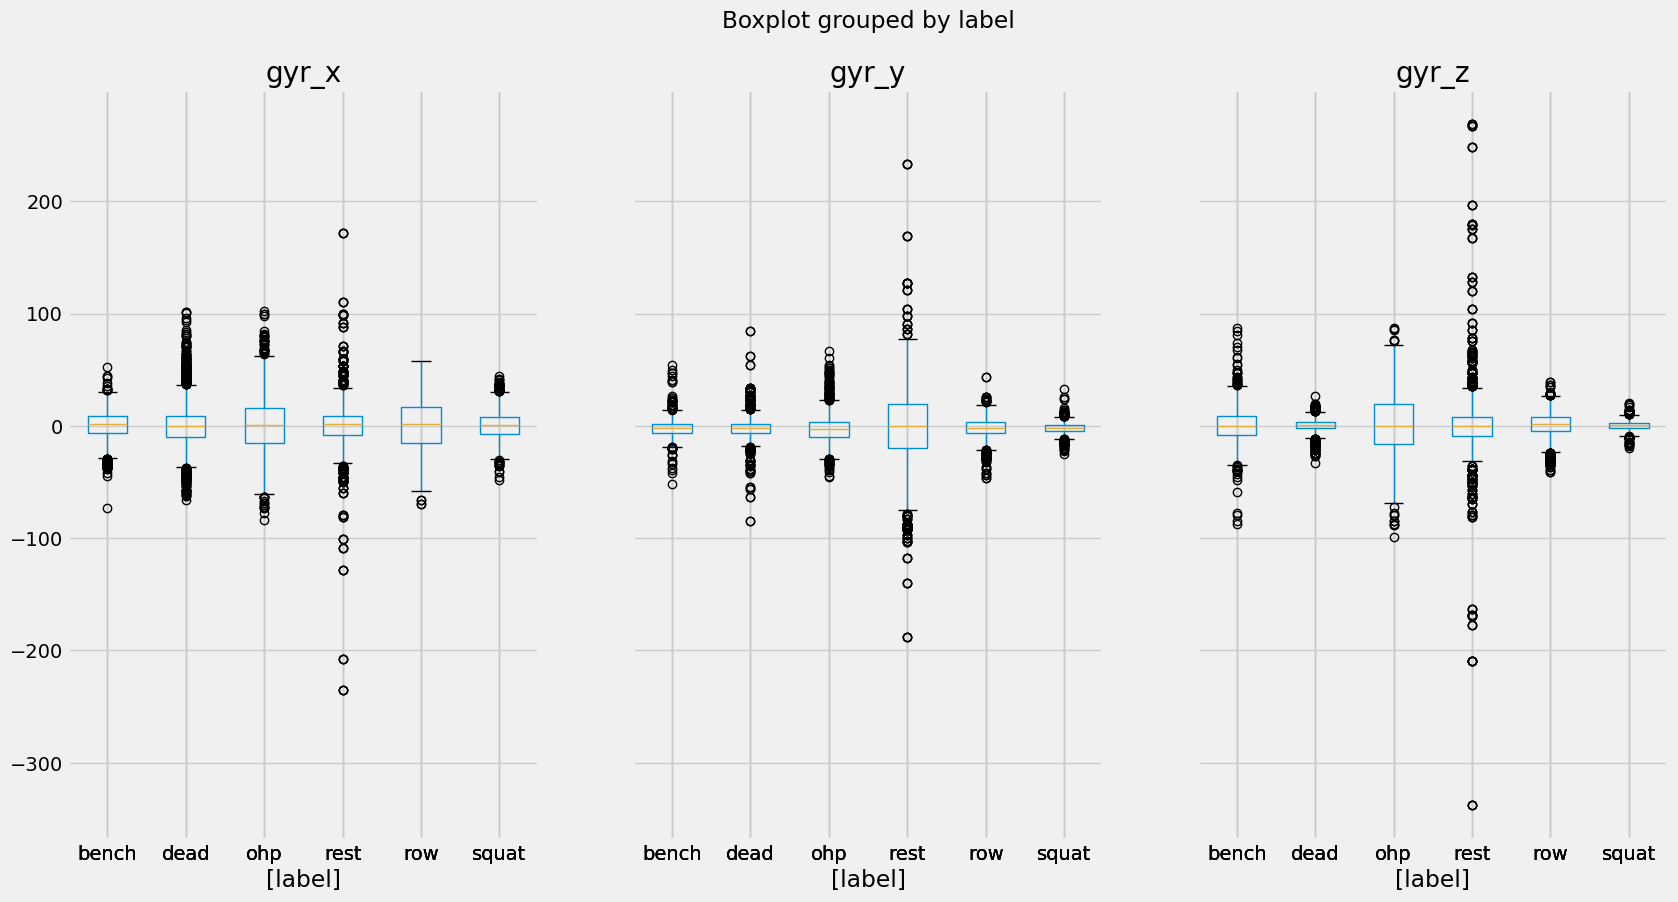

In [205]:
df[outlier_column[:3] + ['label']].boxplot(by = 'label',figsize=(20,10),layout=(1,3))
df[outlier_column[3:] + ['label']].boxplot(by = 'label',figsize=(20,10),layout=(1,3))
plt.show()

In [206]:
def plot_binary_outliers(dataset, col, outlier_col, reset_index):
    """ Plot outliers in case of a binary outlier score. Here, the col specifies the real data
    column and outlier_col the columns with a binary value (outlier or not).

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): Column that you want to plot
        outlier_col (string): Outlier column marked with true/false
        reset_index (bool): whether to reset the index for plotting
    """

   
    dataset = dataset.dropna(axis=0, subset=[col, outlier_col])
    dataset[outlier_col] = dataset[outlier_col].astype("bool")

    if reset_index:
        dataset = dataset.reset_index()

    fig, ax = plt.subplots()

    plt.xlabel("samples")
    plt.ylabel("value")

    # Plot non outliers in default color
    ax.plot(
        dataset.index[~dataset[outlier_col]],
        dataset[col][~dataset[outlier_col]],
        "+",
    )
    # Plot data points that are outliers in red
    ax.plot(
        dataset.index[dataset[outlier_col]],
        dataset[col][dataset[outlier_col]],
        "r+",
    )

    plt.legend(
        ["outlier " + col, "no outlier " + col],
        loc="upper center",
        ncol=2,
        fancybox=True,
        shadow=True,
    )
    plt.show()

In [207]:
def mark_outliers_iqr(dataset, col):
    """Function to mark values as outliers using the IQR method.

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to

    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column 
        indicating whether the value is an outlier or not.
    """

    dataset = dataset.copy()

    Q1 = dataset[col].quantile(0.25)
    Q3 = dataset[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    dataset[col + "_outlier"] = (dataset[col] < lower_bound) | (
        dataset[col] > upper_bound
    )

    return dataset

In [208]:
col = 'acc_x'
df_acc_x = mark_outliers_iqr(df, col)

In [209]:
df_acc_x

acc_x     acc_y     acc_z   gyr_x   gyr_y   gyr_z  \
epoch (ms)                                                                      
2019-01-11 15:08:05.200  0.013500  0.977000 -0.071000 -1.8904  2.4392  0.9388   
2019-01-11 15:08:05.400 -0.001500  0.970500 -0.079500 -1.6826 -0.8904  2.1708   
2019-01-11 15:08:05.600  0.001333  0.971667 -0.064333  2.5608 -0.2560 -1.4146   
2019-01-11 15:08:05.800 -0.024000  0.957000 -0.073500  8.0610 -4.5244 -2.0730   
2019-01-11 15:08:06.000 -0.028000  0.957667 -0.115000  2.4390 -1.5486 -3.6098   
...                           ...       ...       ...     ...     ...     ...   
2019-01-20 17:33:27.000 -0.048000 -1.041500 -0.076500  1.4146 -5.6218  0.2926   
2019-01-20 17:33:27.200 -0.037000 -1.030333 -0.053333 -2.7684 -0.5854  2.2440   
2019-01-20 17:33:27.400 -0.060000 -1.031000 -0.082000  2.8416 -5.1342 -0.1220   
2019-01-20 17:33:27.600 -0.038667 -1.025667 -0.044667 -0.2318  0.2562  1.1220   
2019-01-20 17:33:27.800 -0.044000 -1.034000 -0.059000  1.0980 -4.0240  0.9760   

                        participant  label category  set  acc_x_outlier  
epoch (ms)                                                               
2019-01-11 15:08:05.200           B  bench    heavy   30          False  
2019-01-11 15:08:05.400           B  bench    heavy   30          False  
2019-01-11 15:08:05.600           B  bench    heavy   30          False  
2019-01-11 15:08:05.800           B  bench    heavy   30          False  
2019-01-11 15:08:06.000           B  bench    heavy   30          False  
...                             ...    ...      ...  ...            ...  
2019-01-20 17:33:27.000           E    row   medium   90          False  
2019-01-20 17:33:27.200           E    row   medium   90          False  
2019-01-20 17:33:27.400           E    row   medium   90          False  
2019-01-20 17:33:27.600           E    row   medium   90          False  
2019-01-20 17:33:27.800           E    row   medium   90          False  

[9009 rows x 11 columns]

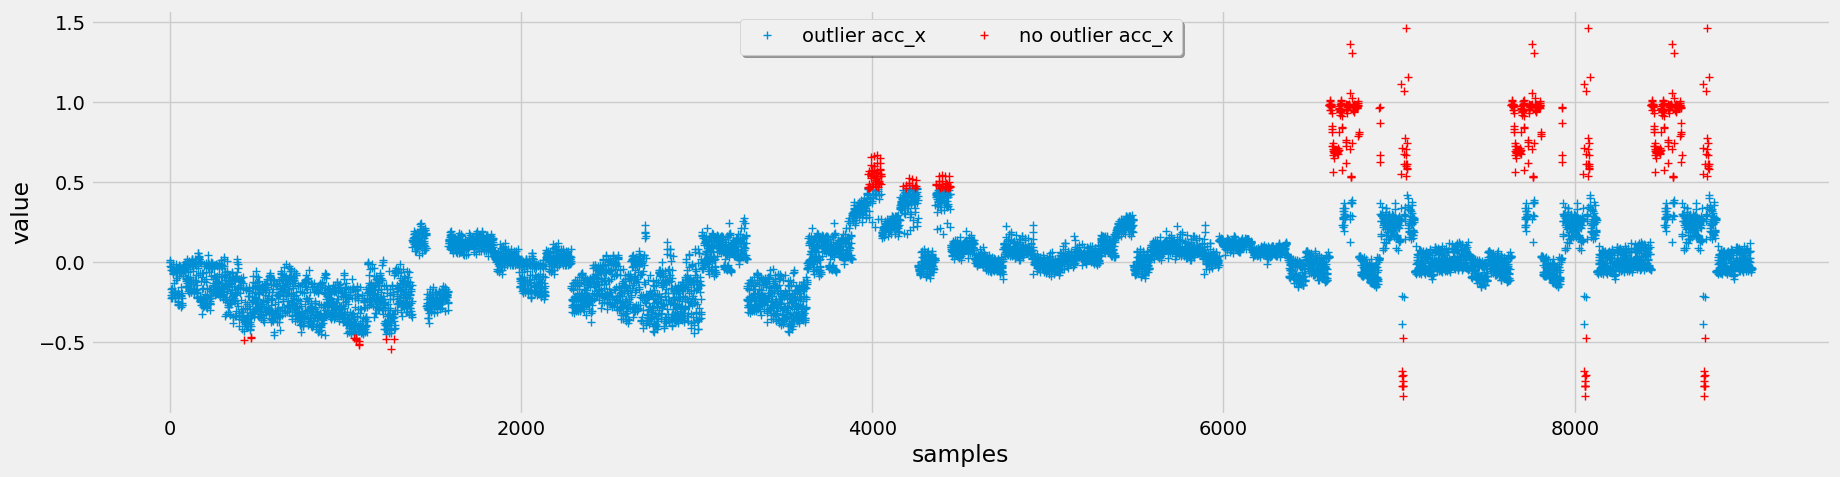

In [210]:
plot_binary_outliers(df_acc_x, col, col + "_outlier", reset_index=True)

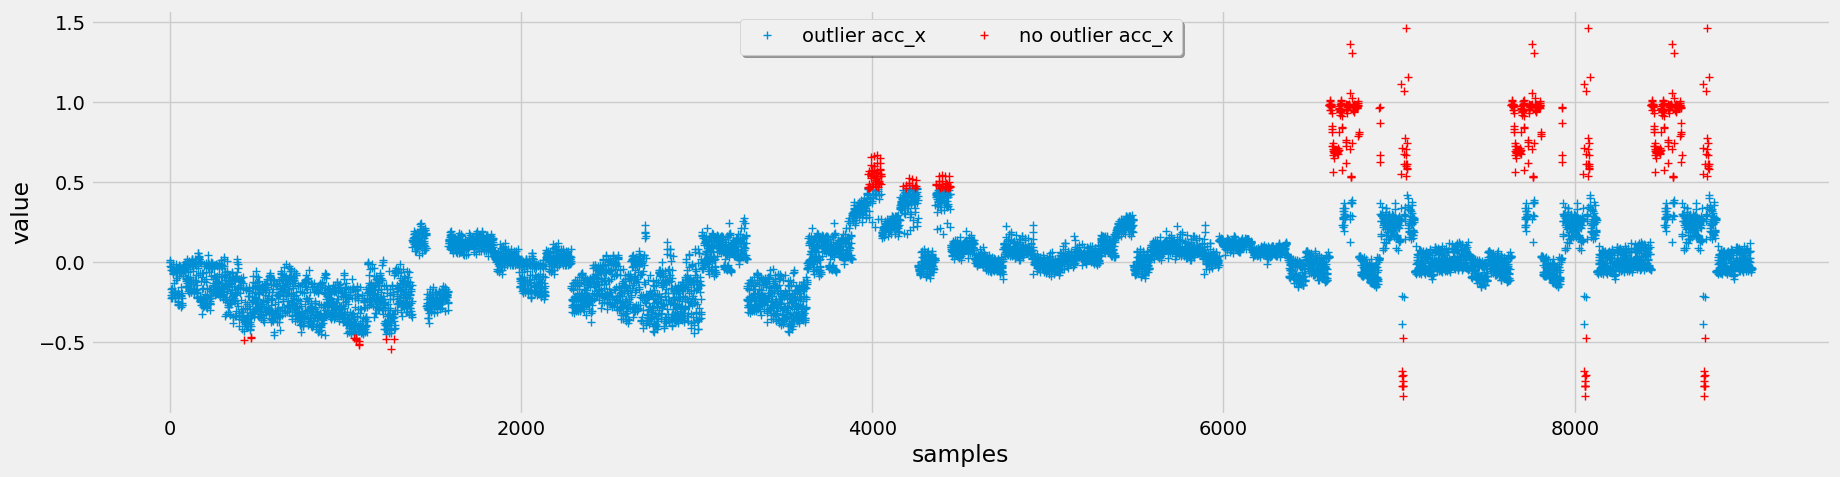

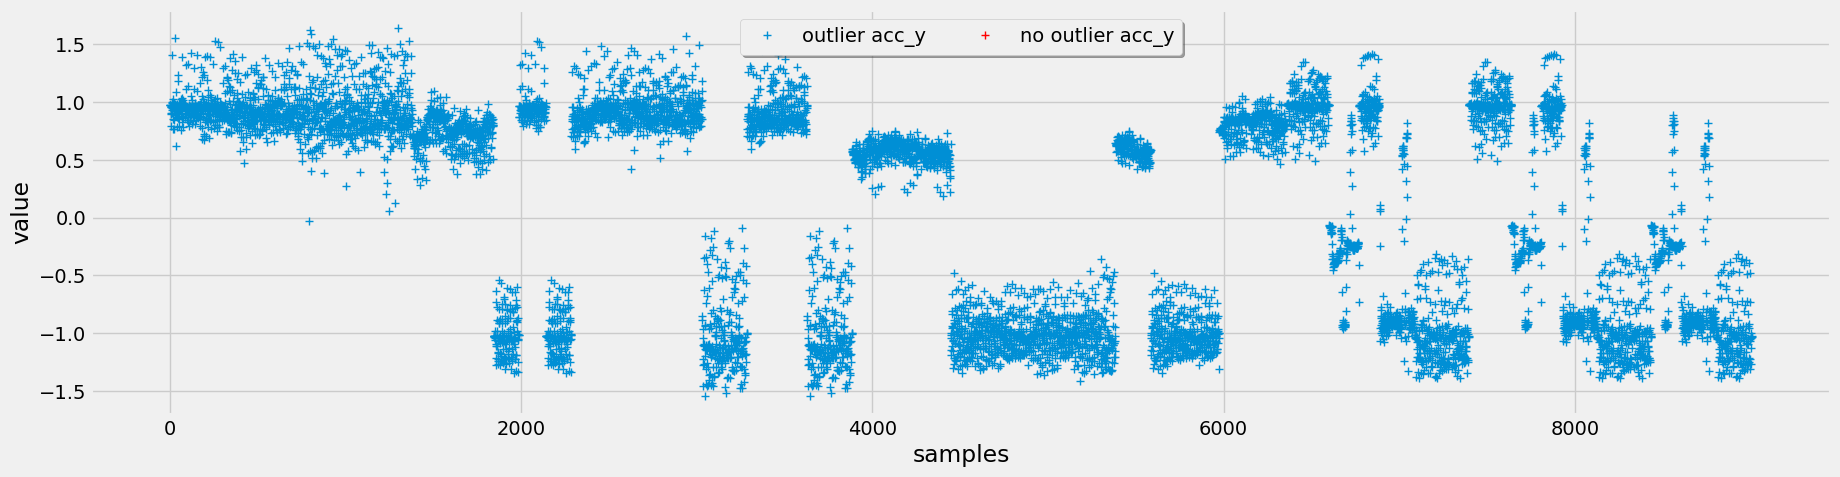

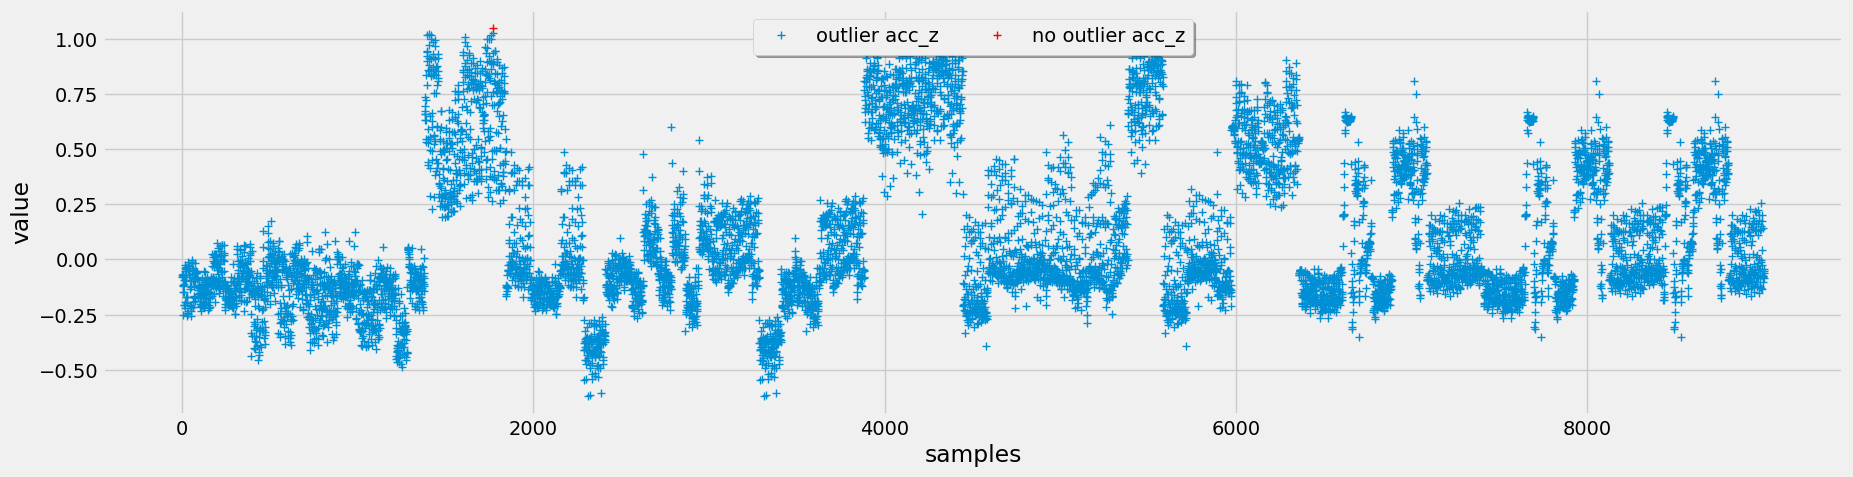

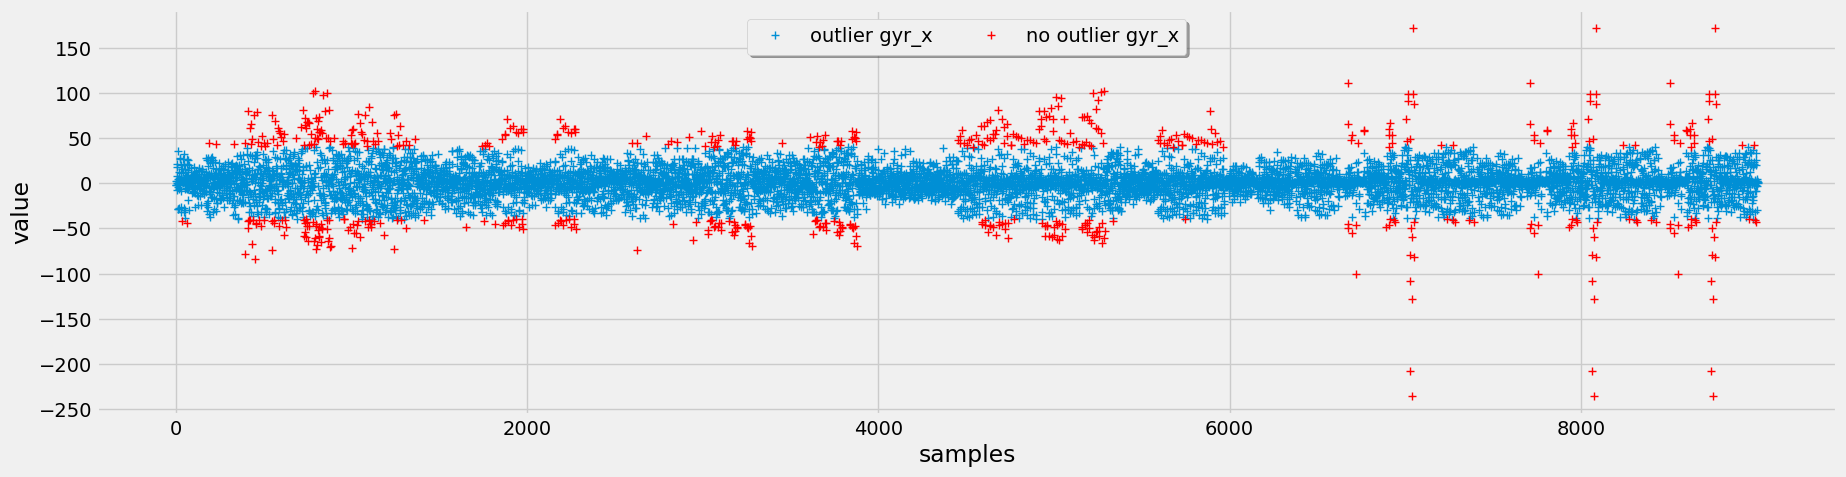

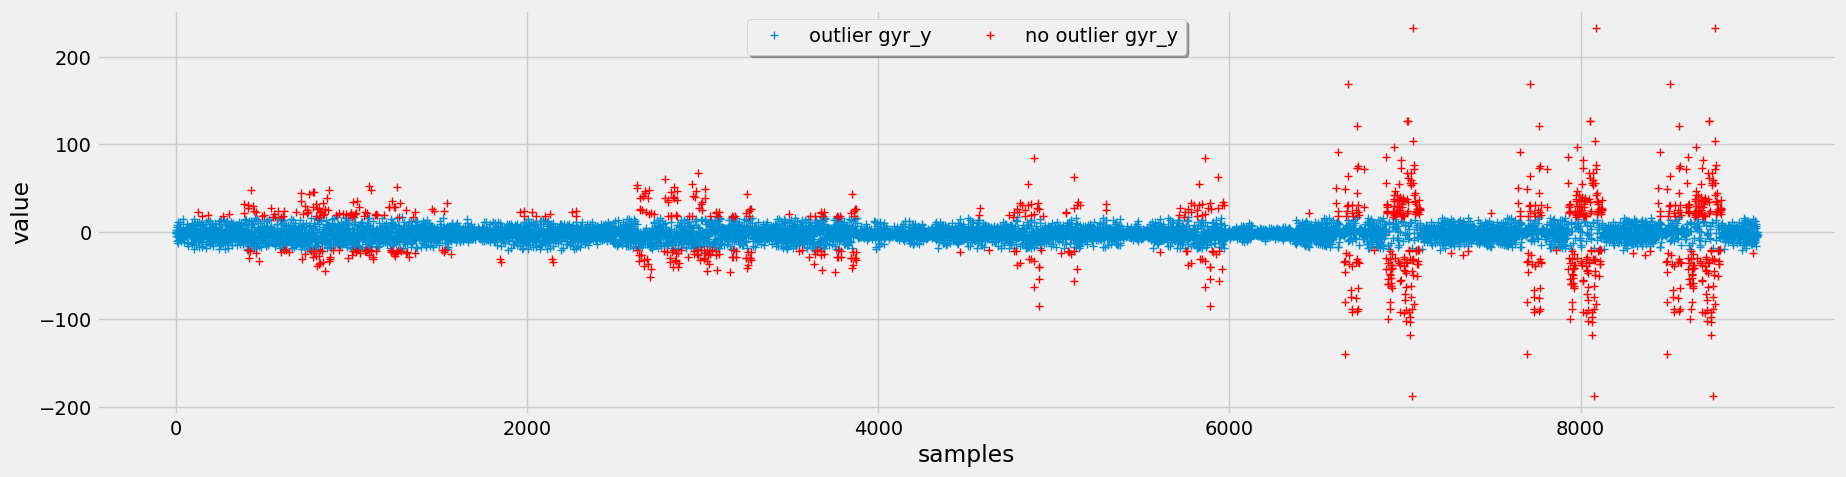

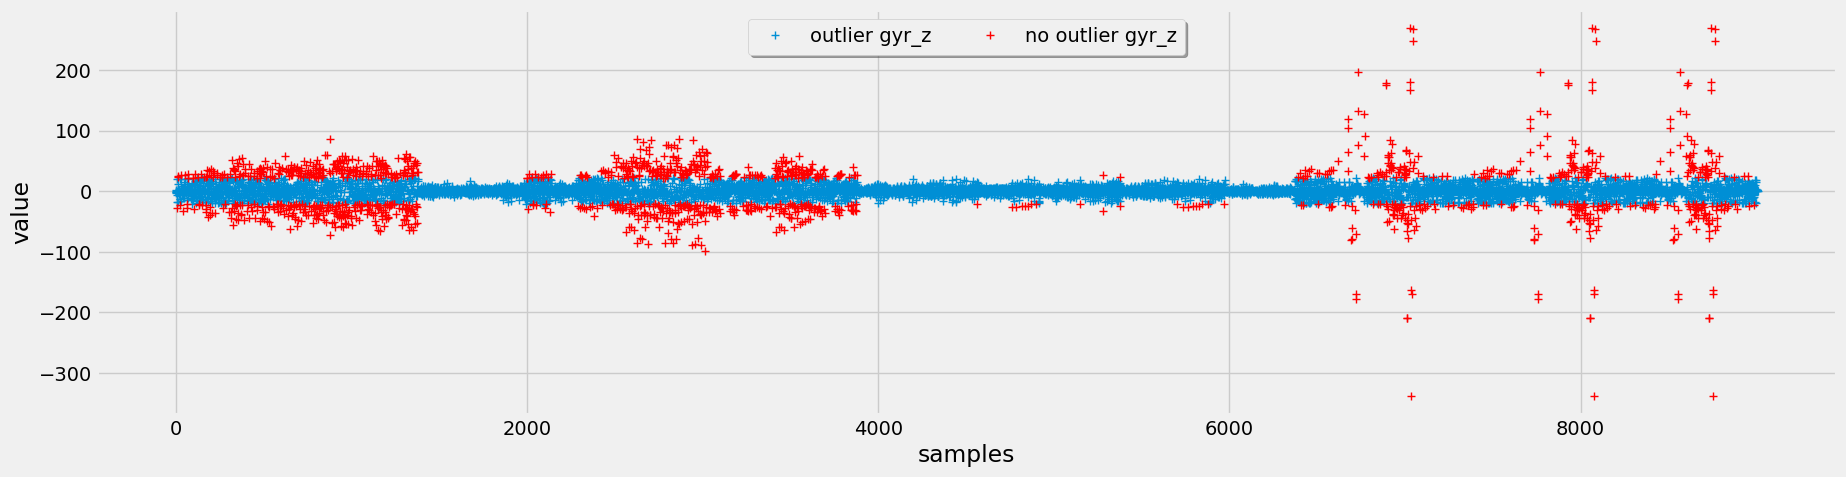

In [211]:
columns = df.columns[:6]
for col in columns:
    df_without_outliers = mark_outliers_iqr(df, col)
    plot_binary_outliers(df_without_outliers, col, col + "_outlier", reset_index=True)
    


In [212]:
def mark_outliers_chauvenet(dataset, col, C=2):
    """Finds outliers in the specified column of datatable and adds a binary column with
    the same name extended with '_outlier' that expresses the result per data point.
    

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to
        C (int, optional): Degree of certainty for the identification of outliers given the assumption 
                           of a normal distribution, typicaly between 1 - 10. Defaults to 2.

    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column 
        indicating whether the value is an outlier or not.
    """

    dataset = dataset.copy()
    # Compute the mean and standard deviation.
    mean = dataset[col].mean()
    std = dataset[col].std()
    N = len(dataset.index)
    criterion = 1.0 / (C * N)

    # Consider the deviation for the data points.
    deviation = abs(dataset[col] - mean) / std

    # Express the upper and lower bounds.
    low = -deviation / math.sqrt(C)
    high = deviation / math.sqrt(C)
    prob = []
    mask = []

    # Pass all rows in the dataset.
    for i in range(0, len(dataset.index)):
        # Determine the probability of observing the point
        prob.append(
            1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
        )
        # And mark as an outlier when the probability is below our criterion.
        mask.append(prob[i] < criterion)
    dataset[col + "_outlier"] = mask
    return dataset

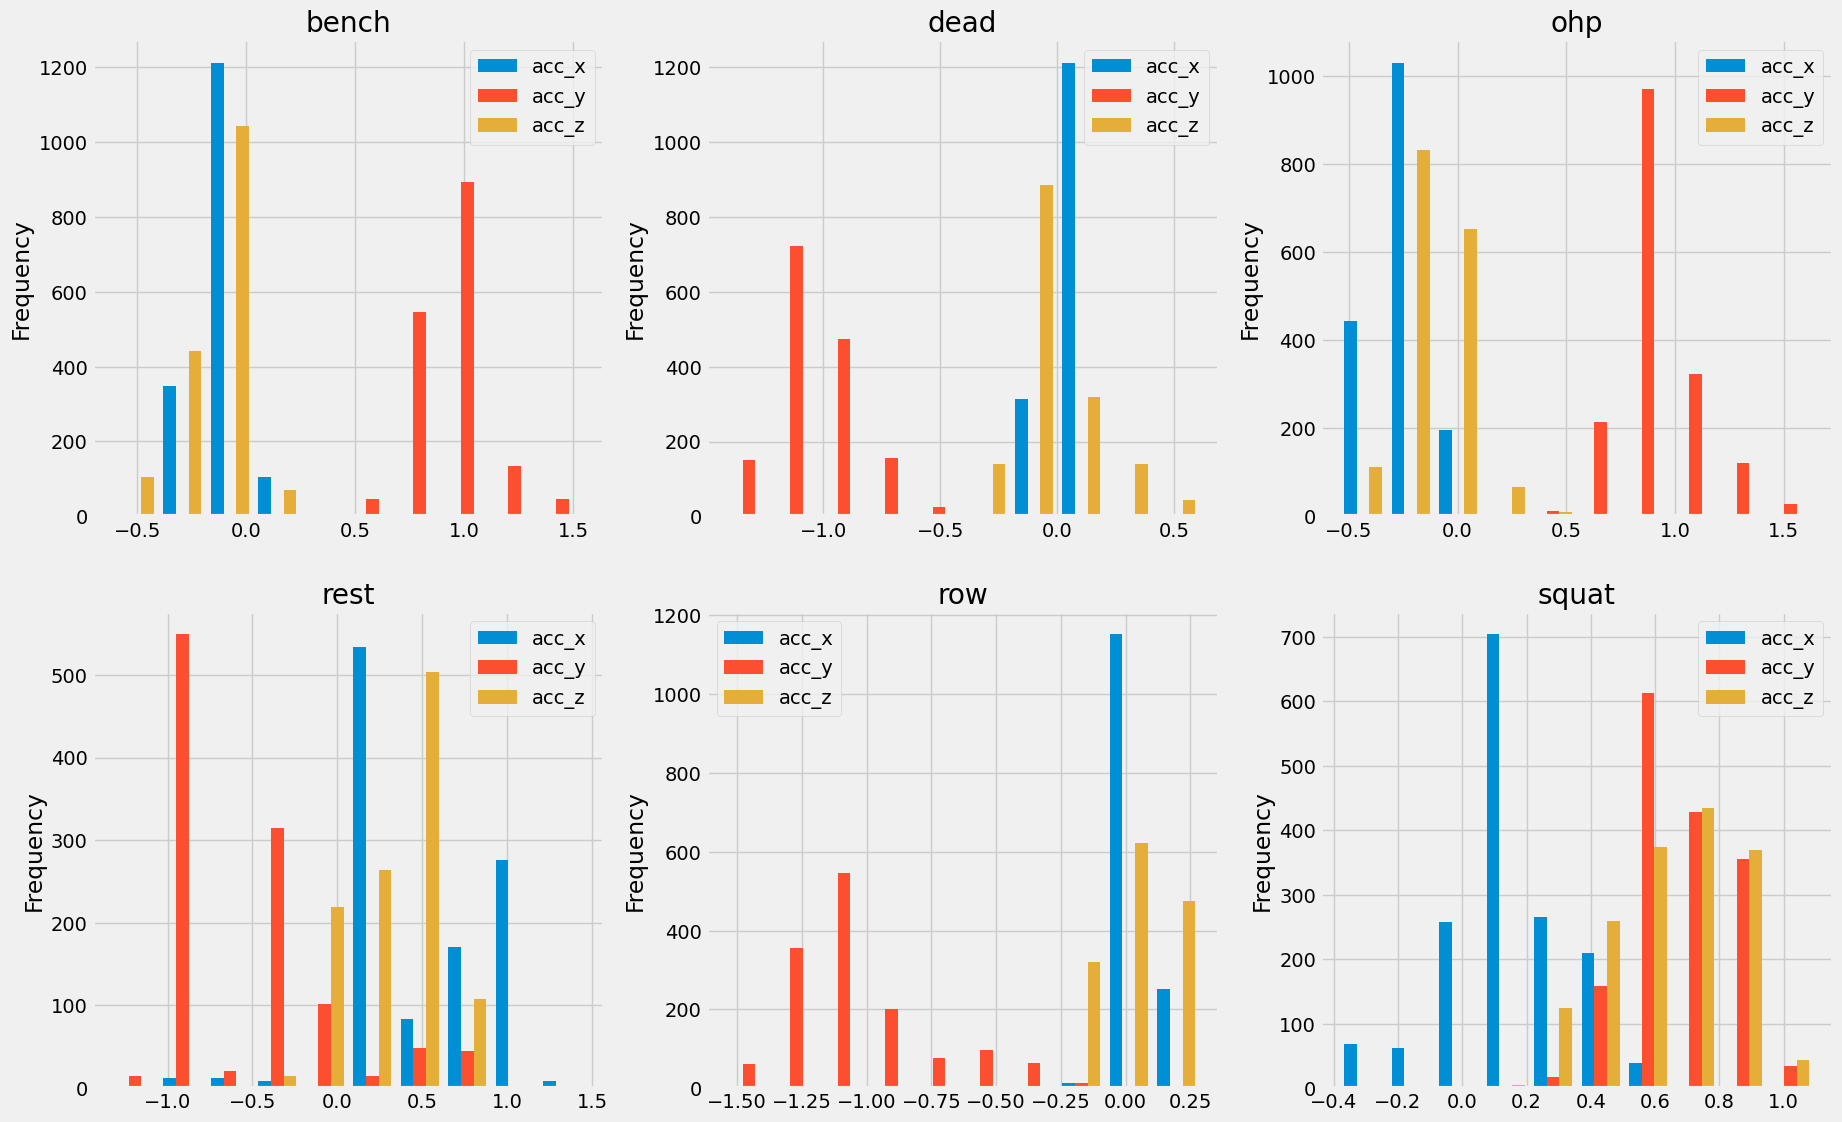

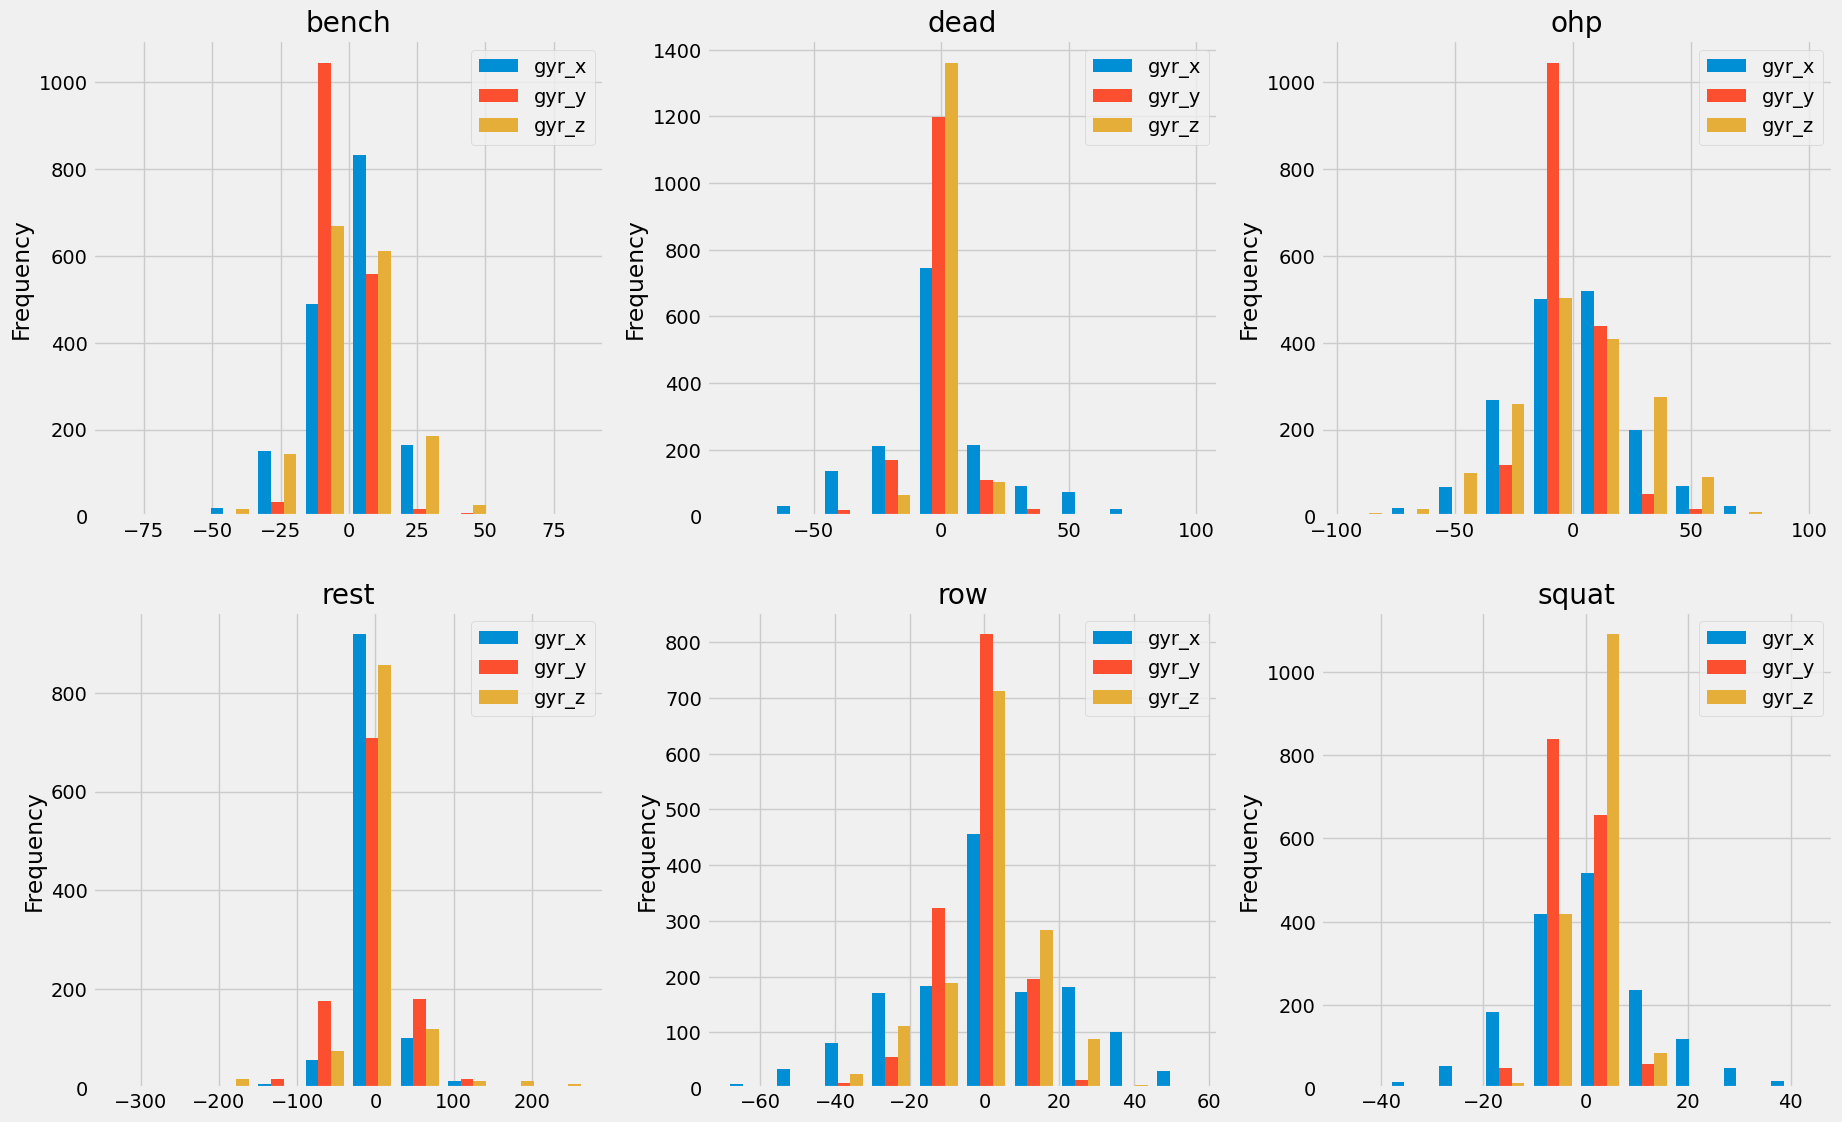

In [213]:
df[outlier_column[:3] + ['label']].plot.hist(by = 'label',figsize=(20,20),layout=(3,3))
df[outlier_column[3:] + ['label']].plot.hist(by = 'label',figsize=(20,20),layout=(3,3))
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_20216\535511939.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))


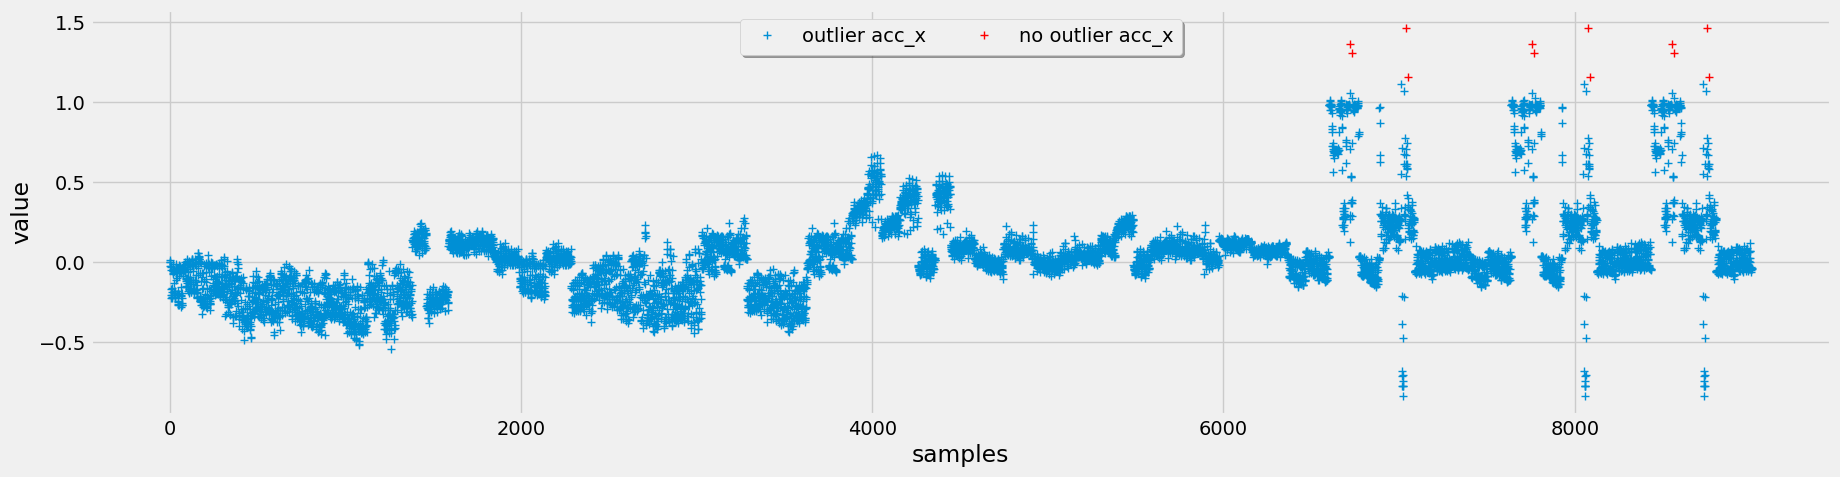

C:\Users\user\AppData\Local\Temp\ipykernel_20216\535511939.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))


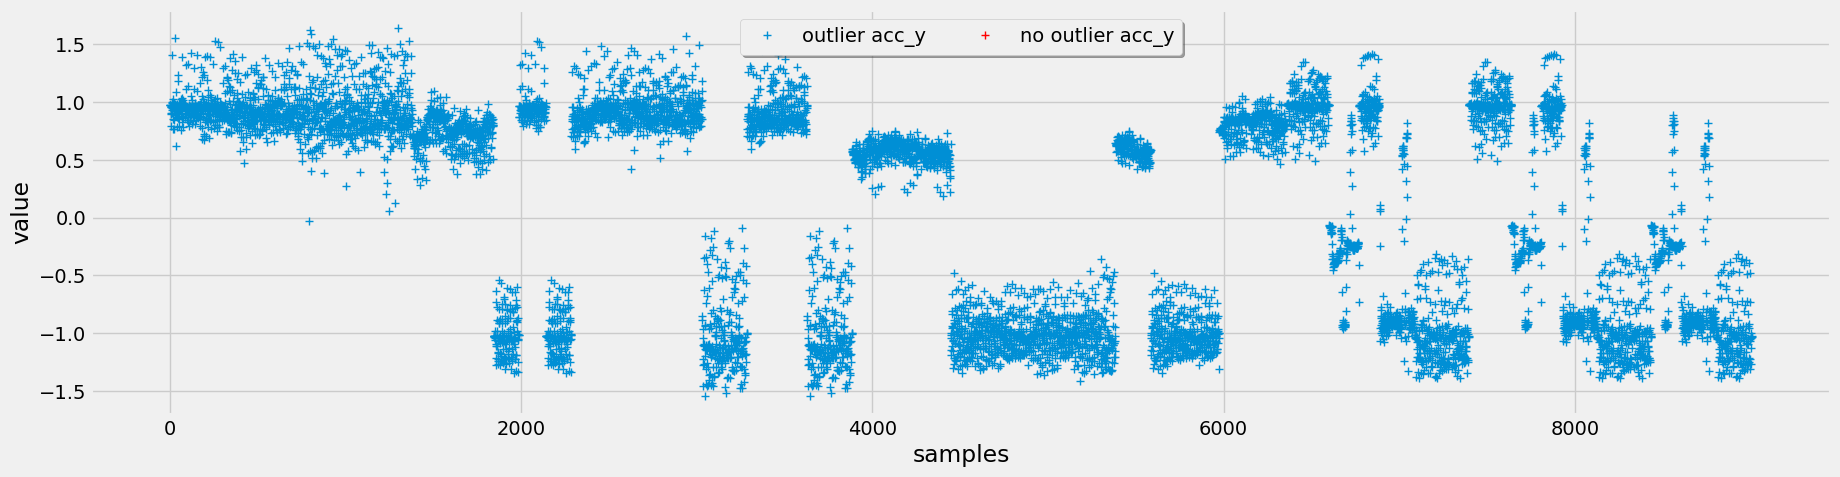

C:\Users\user\AppData\Local\Temp\ipykernel_20216\535511939.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))


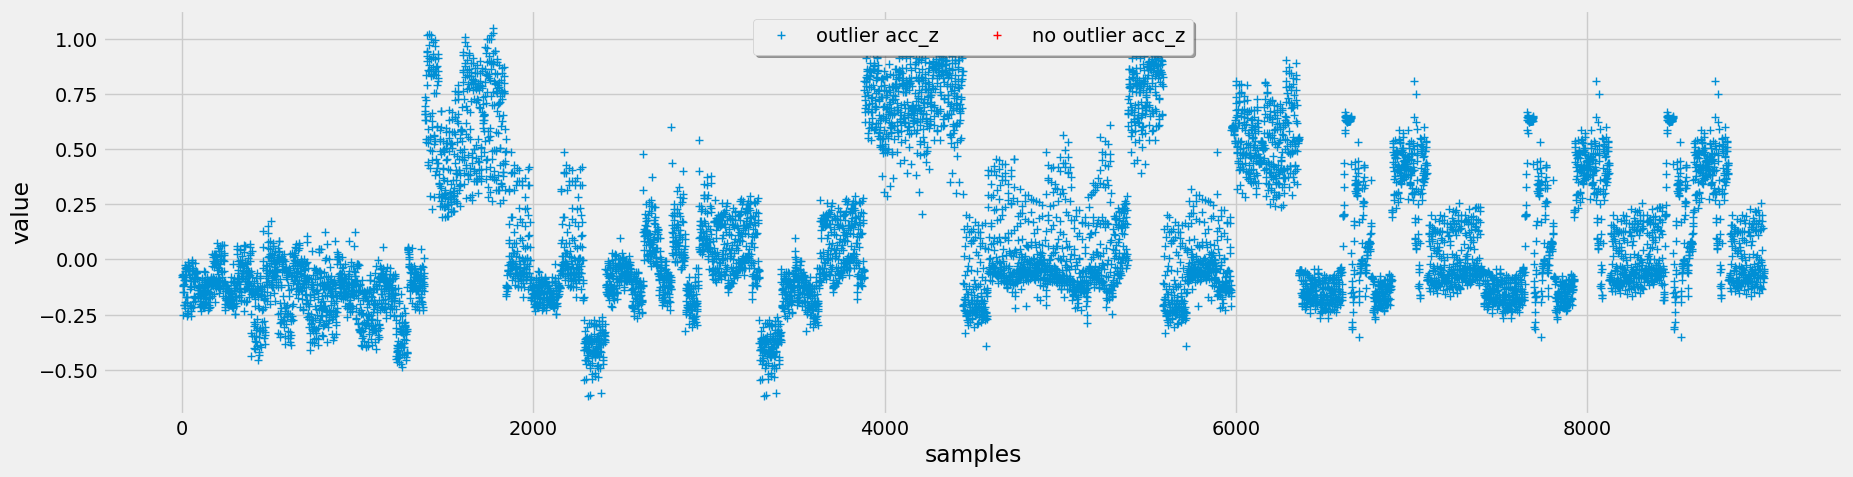

C:\Users\user\AppData\Local\Temp\ipykernel_20216\535511939.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))


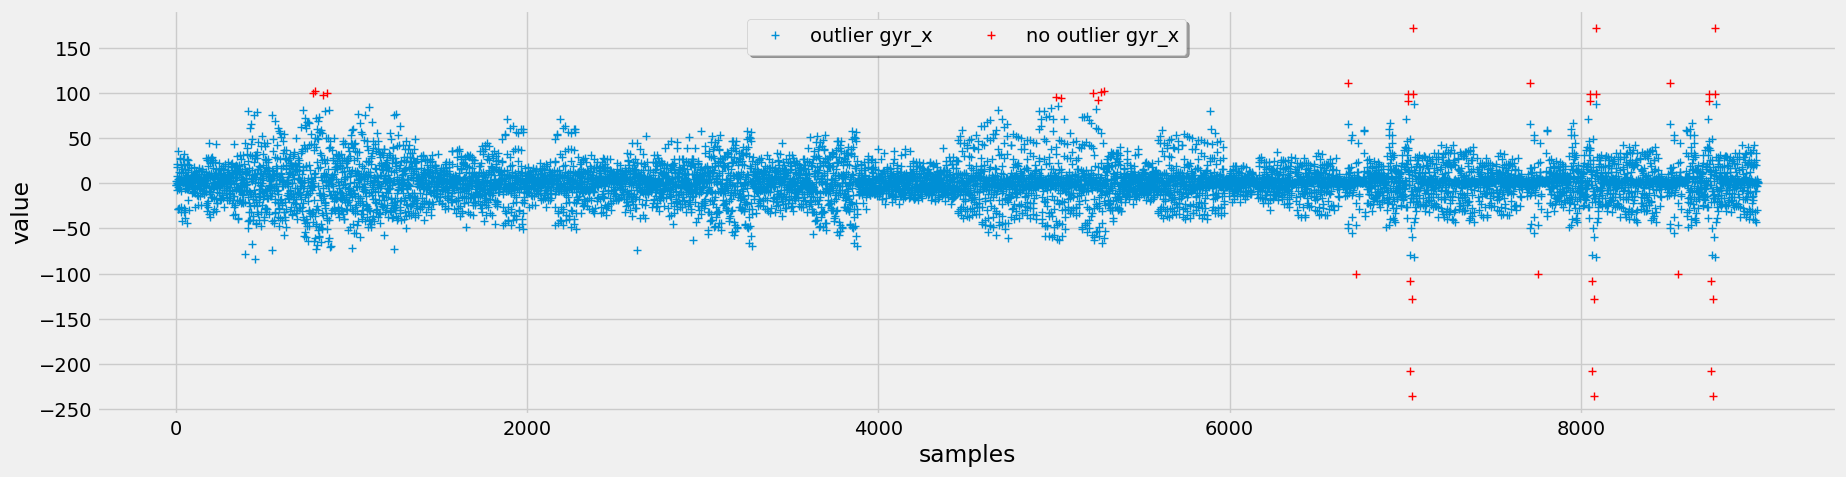

C:\Users\user\AppData\Local\Temp\ipykernel_20216\535511939.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))


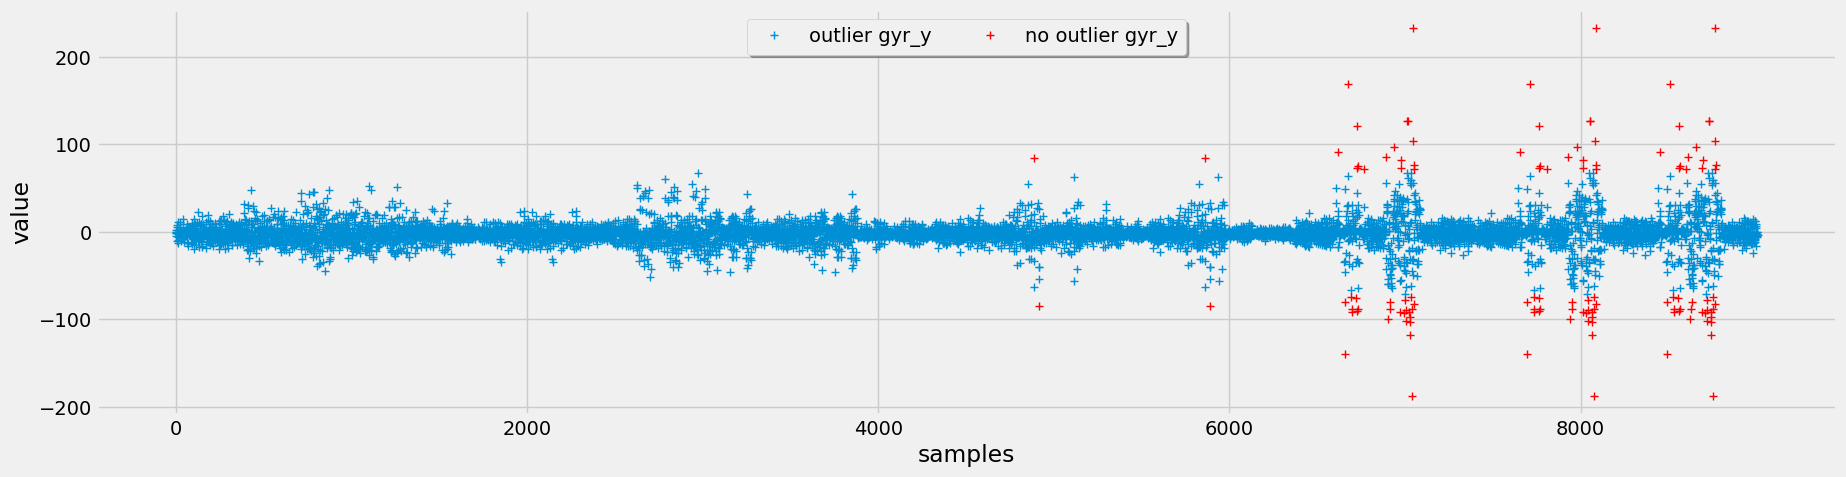

C:\Users\user\AppData\Local\Temp\ipykernel_20216\535511939.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))


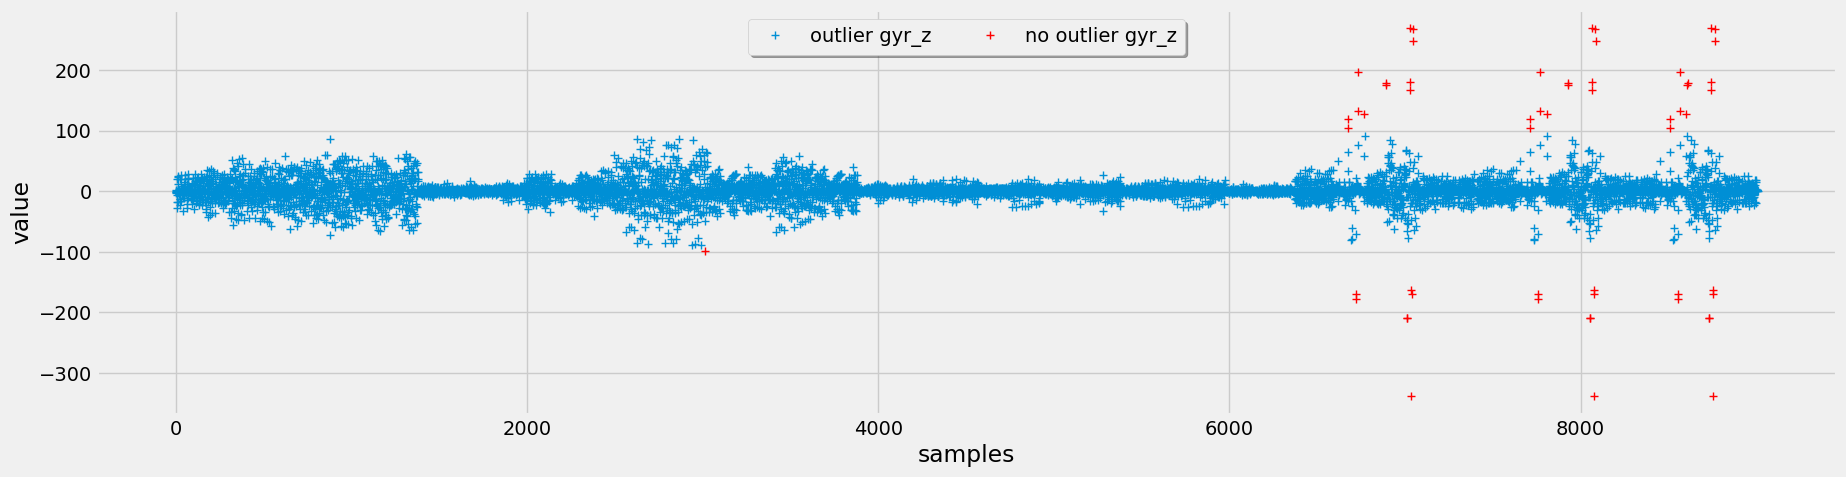

In [214]:
columns = df.columns[:6]
for col in columns:
    df_without_outliers = mark_outliers_chauvenet(df, col)
    plot_binary_outliers(df_without_outliers, col, col + "_outlier", reset_index=True)

In [215]:
def mark_outliers_lof(dataset, columns, n=20):
    """Mark values as outliers using LOF

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to
        n (int, optional): n_neighbors. Defaults to 20.
    
    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column
        indicating whether the value is an outlier or not.
    """
    
    dataset = dataset.copy()

    lof = LocalOutlierFactor(n_neighbors=n)
    data = dataset[columns]
    outliers = lof.fit_predict(data)
    X_scores = lof.negative_outlier_factor_

    dataset["outlier_lof"] = outliers == -1
    return dataset, outliers, X_scores

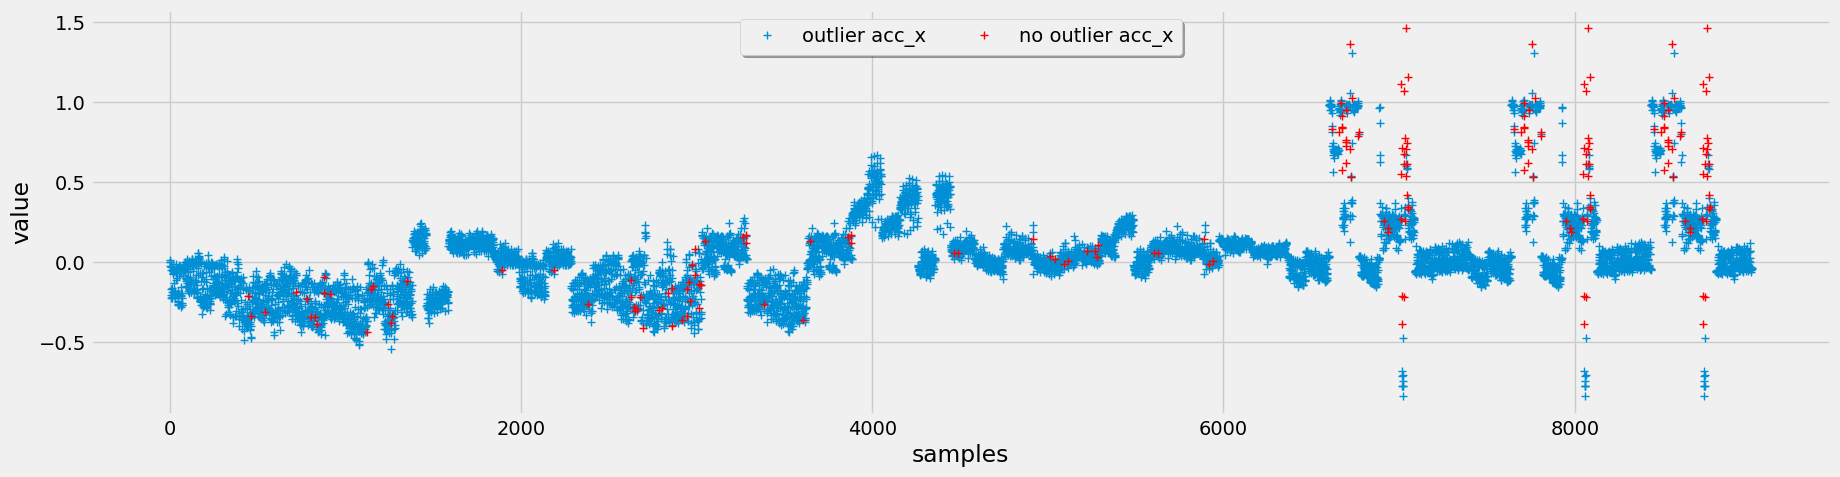

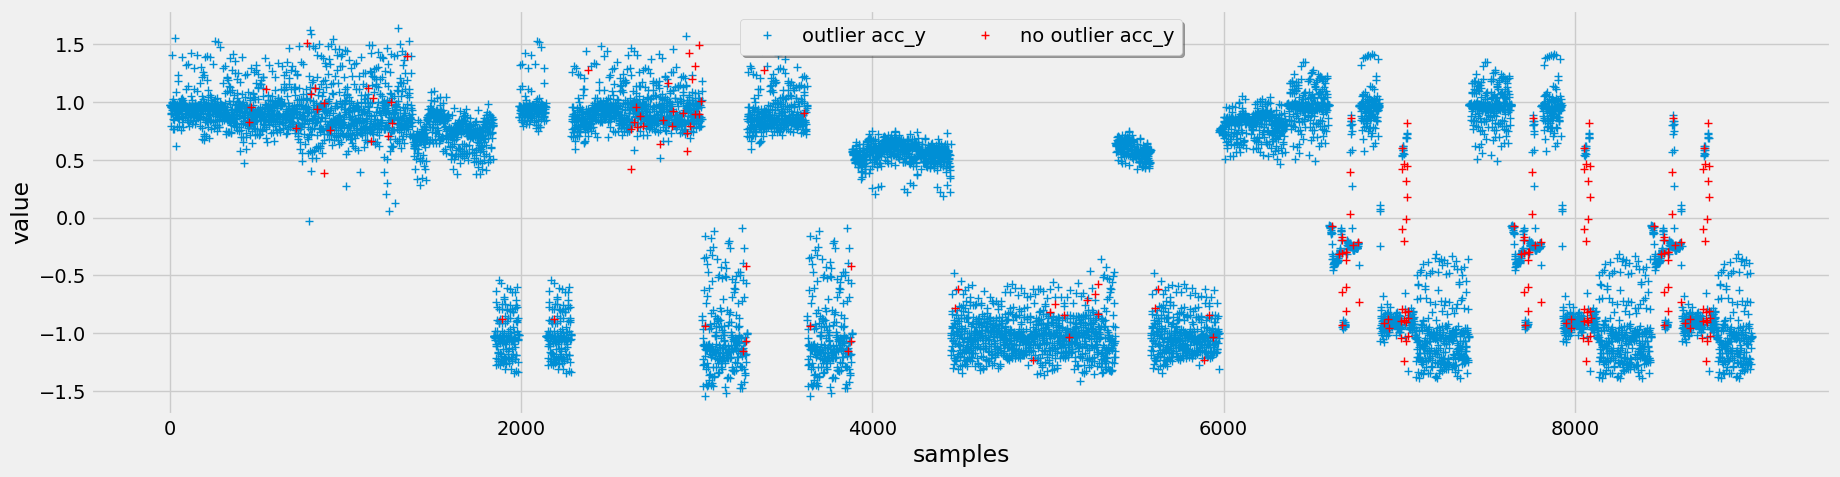

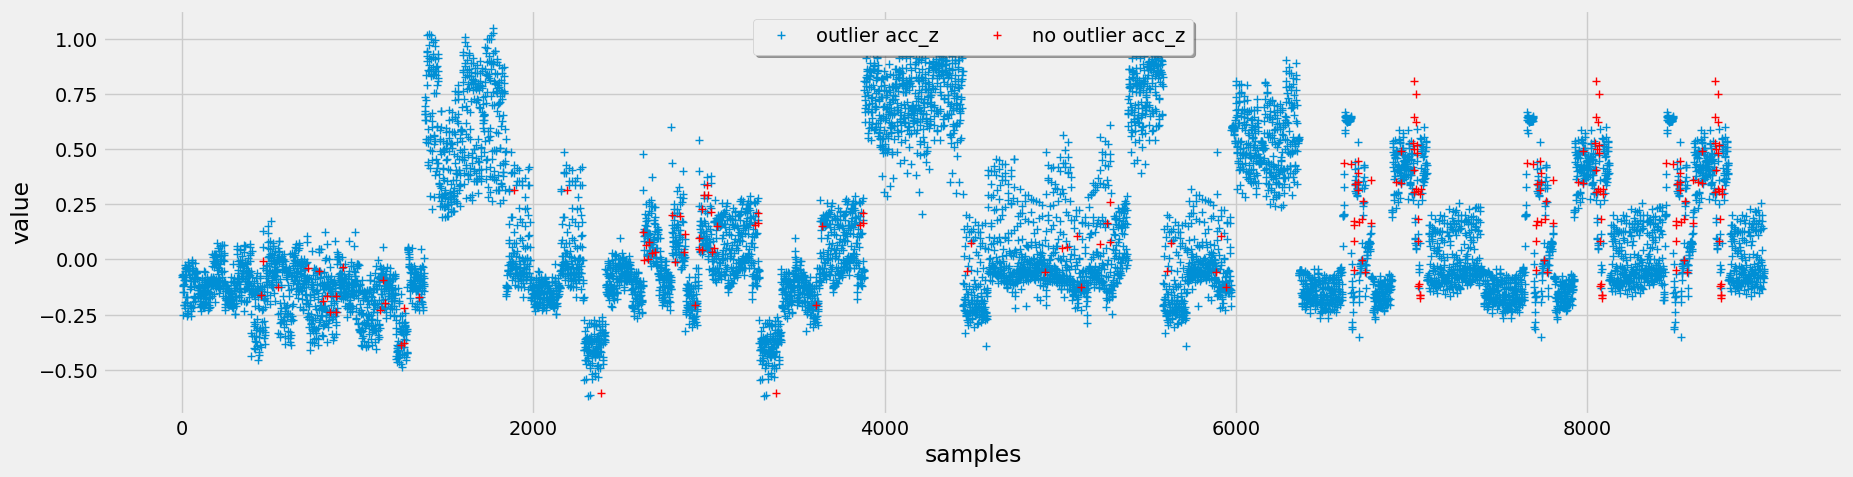

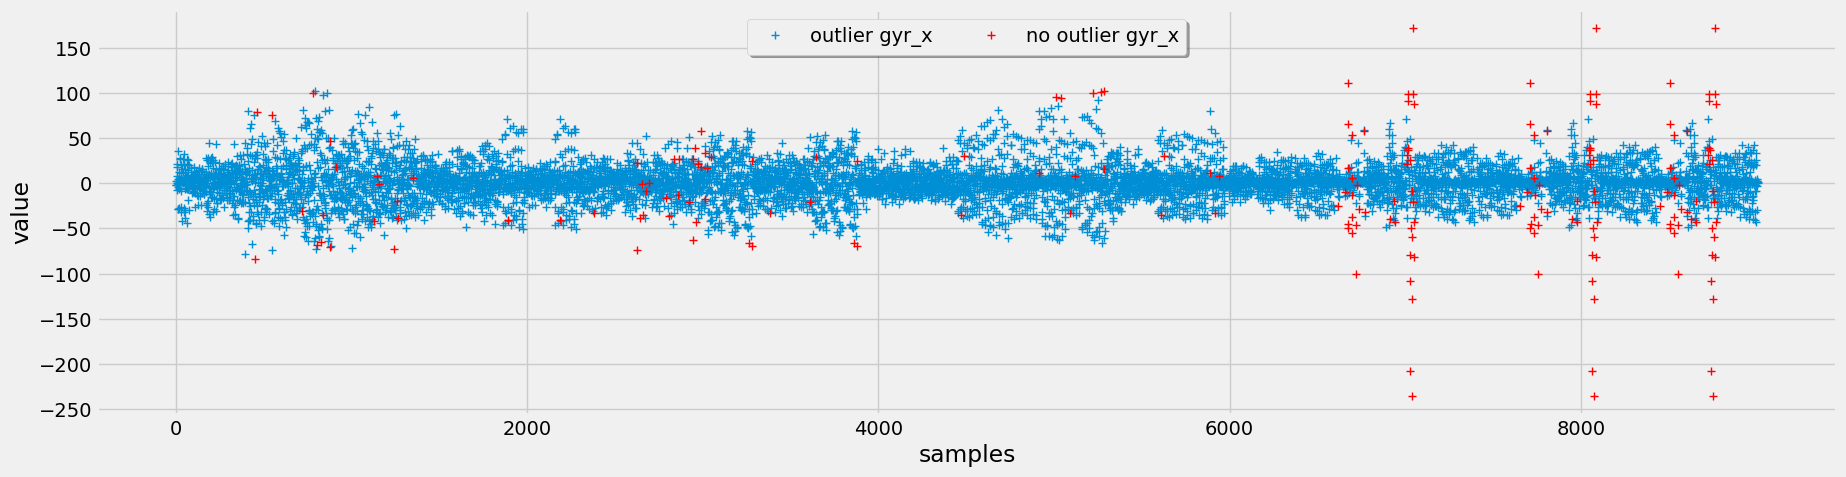

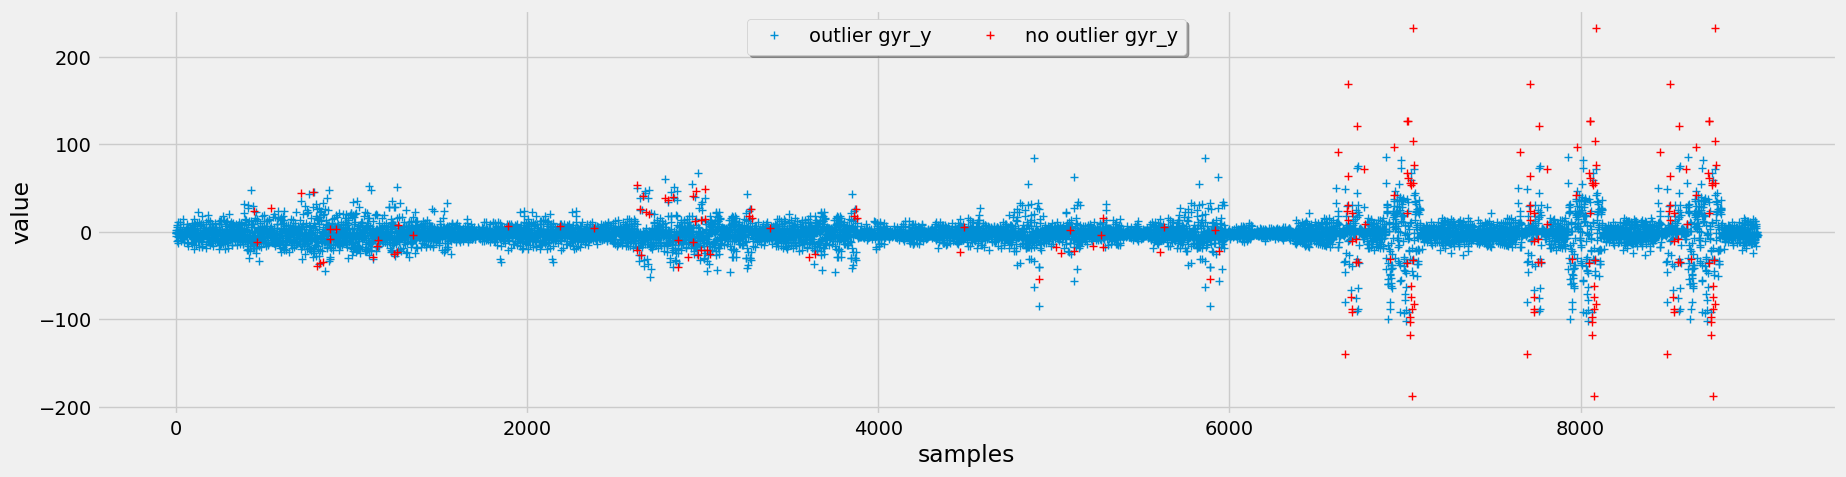

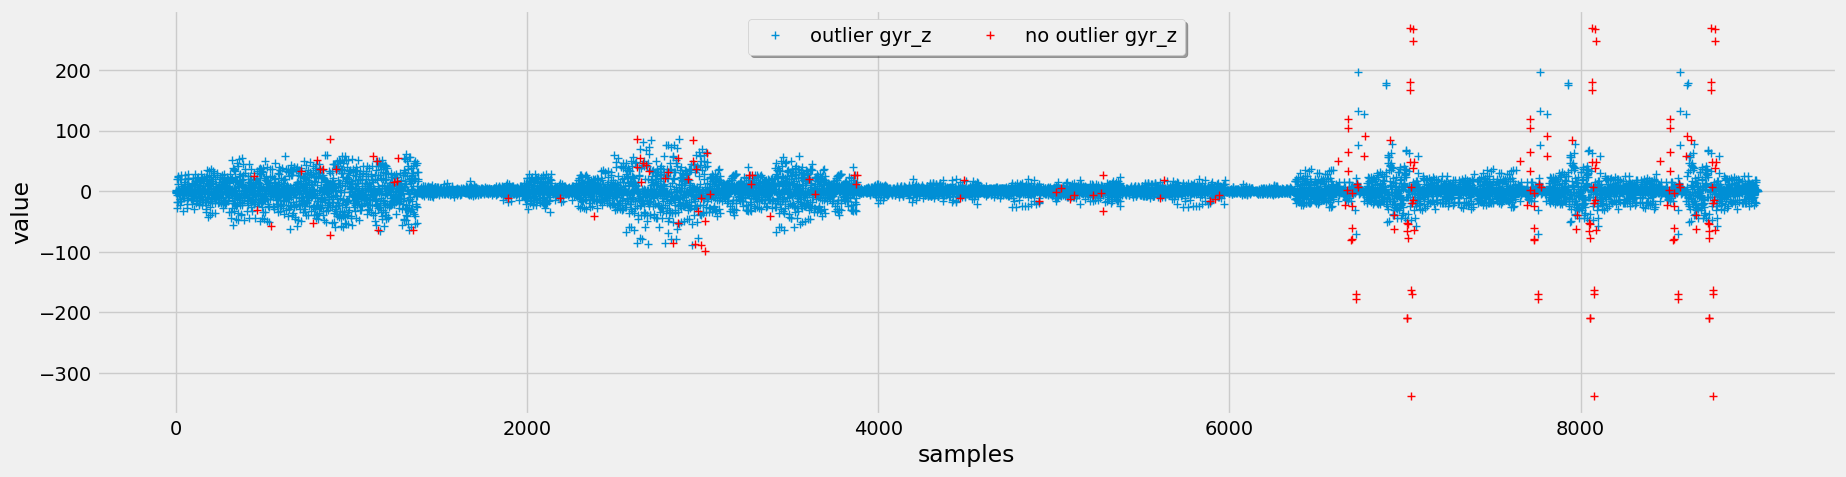

In [216]:
columns = df.columns[:6]
df_with_outliers, outliers, X_score = mark_outliers_lof(df, outlier_column, n=20)
for col in columns:
    plot_binary_outliers(df_with_outliers, col, "outlier_lof", reset_index=True)

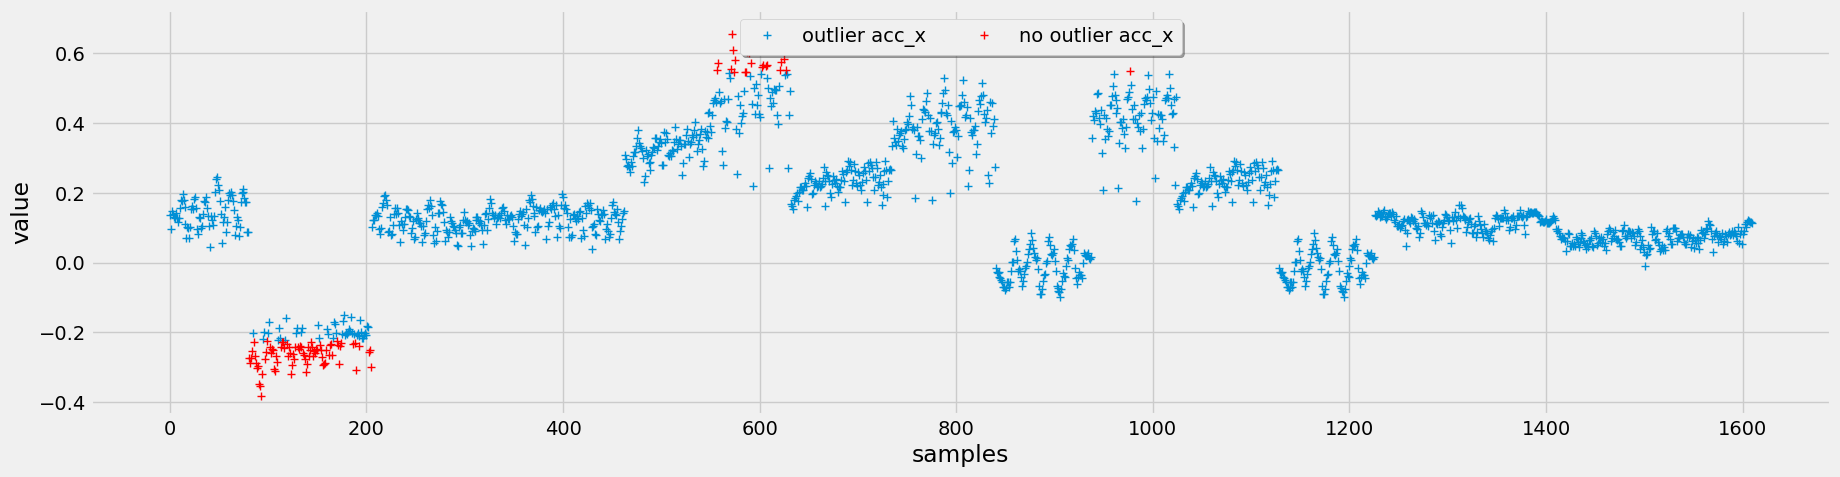

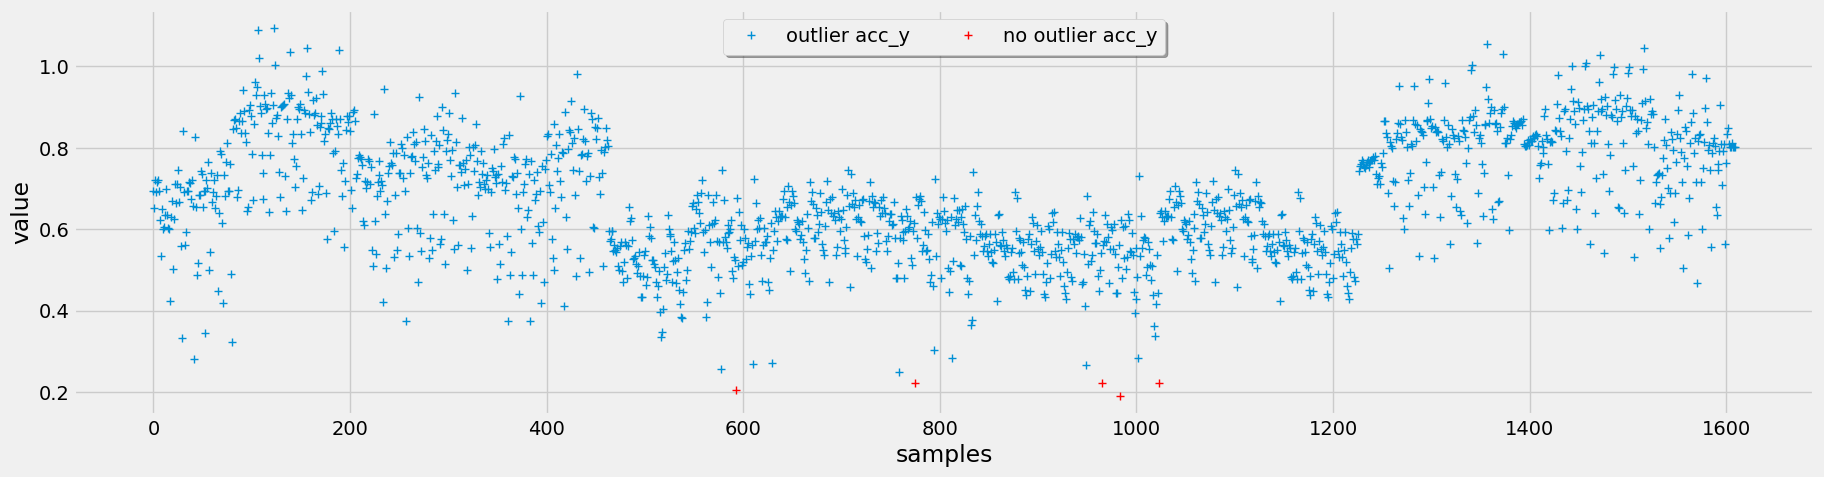

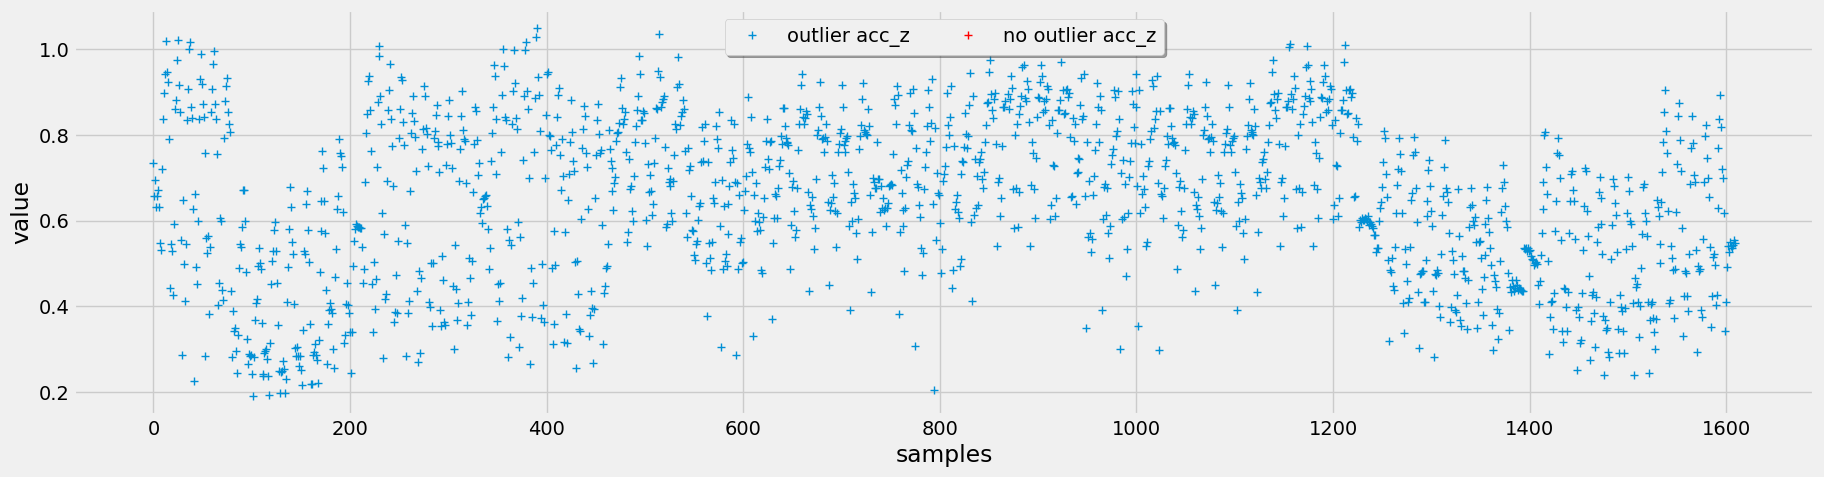

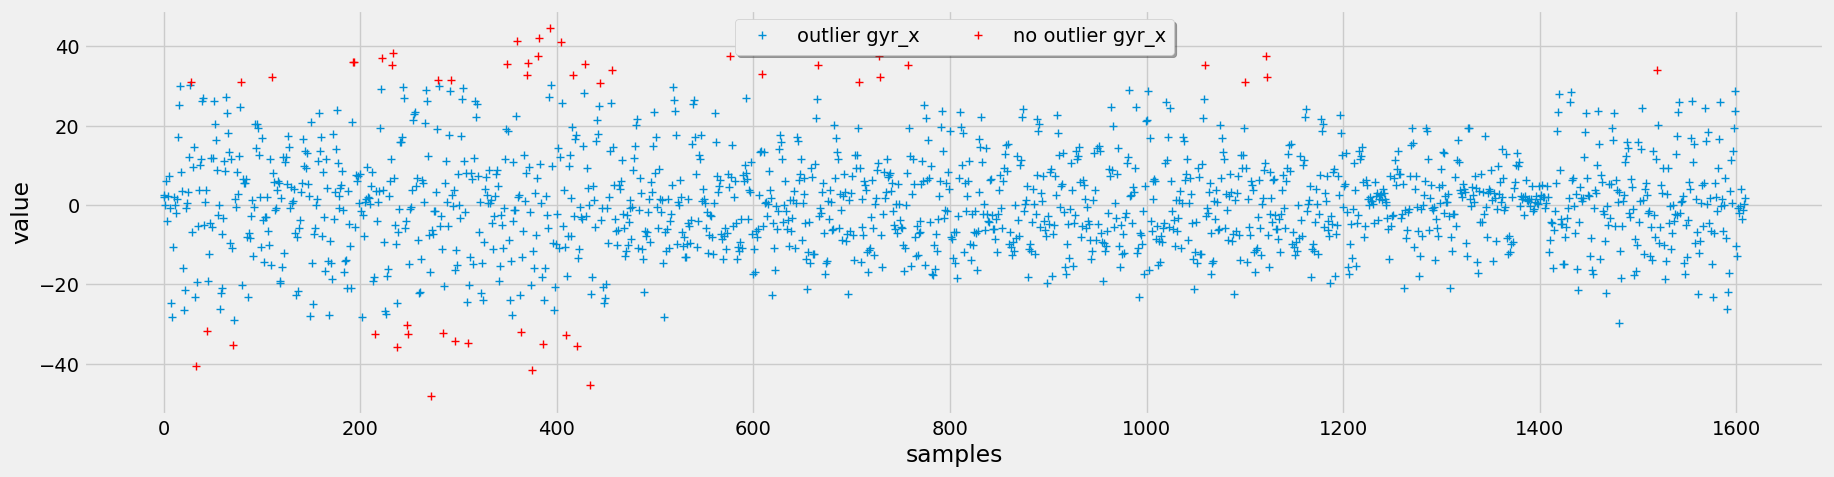

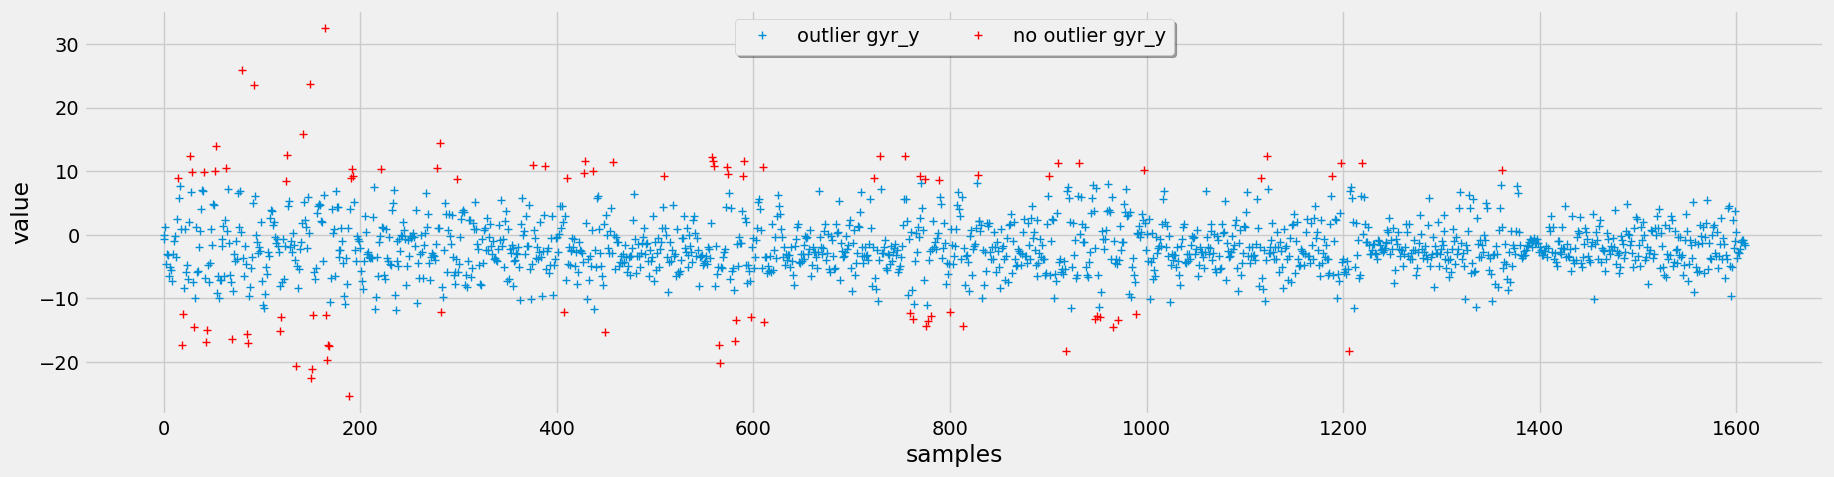

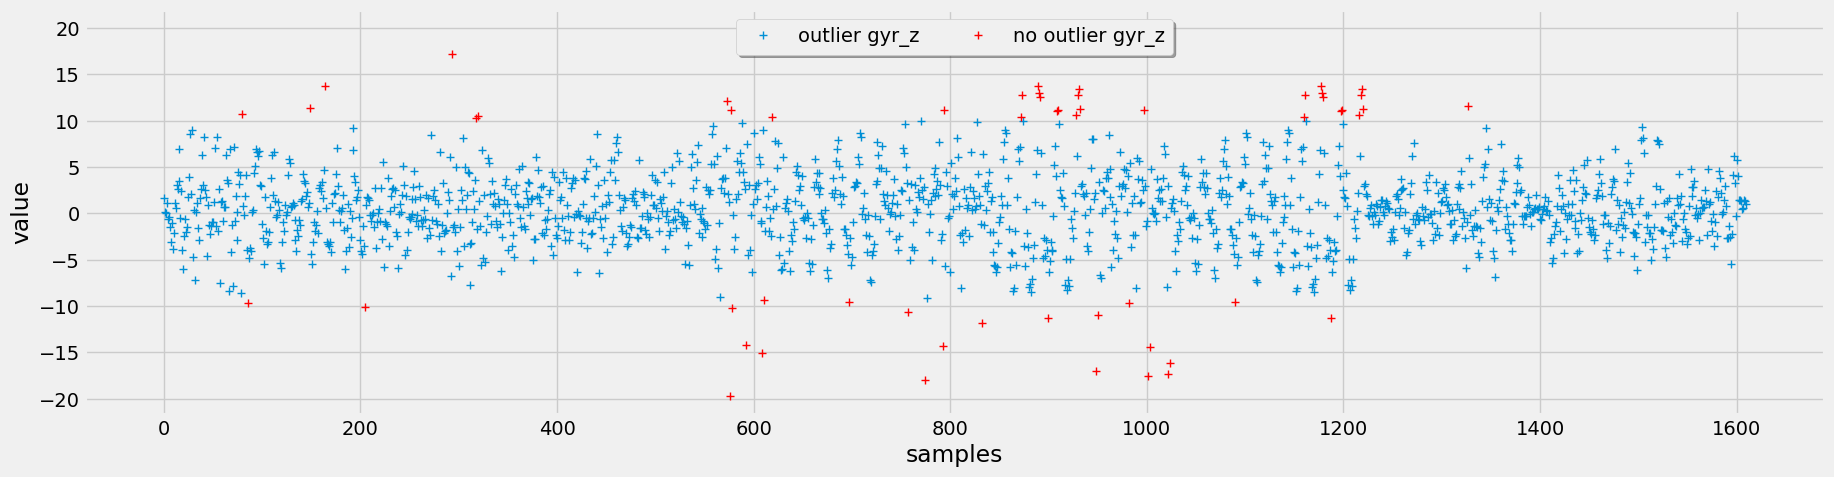

C:\Users\user\AppData\Local\Temp\ipykernel_20216\535511939.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))


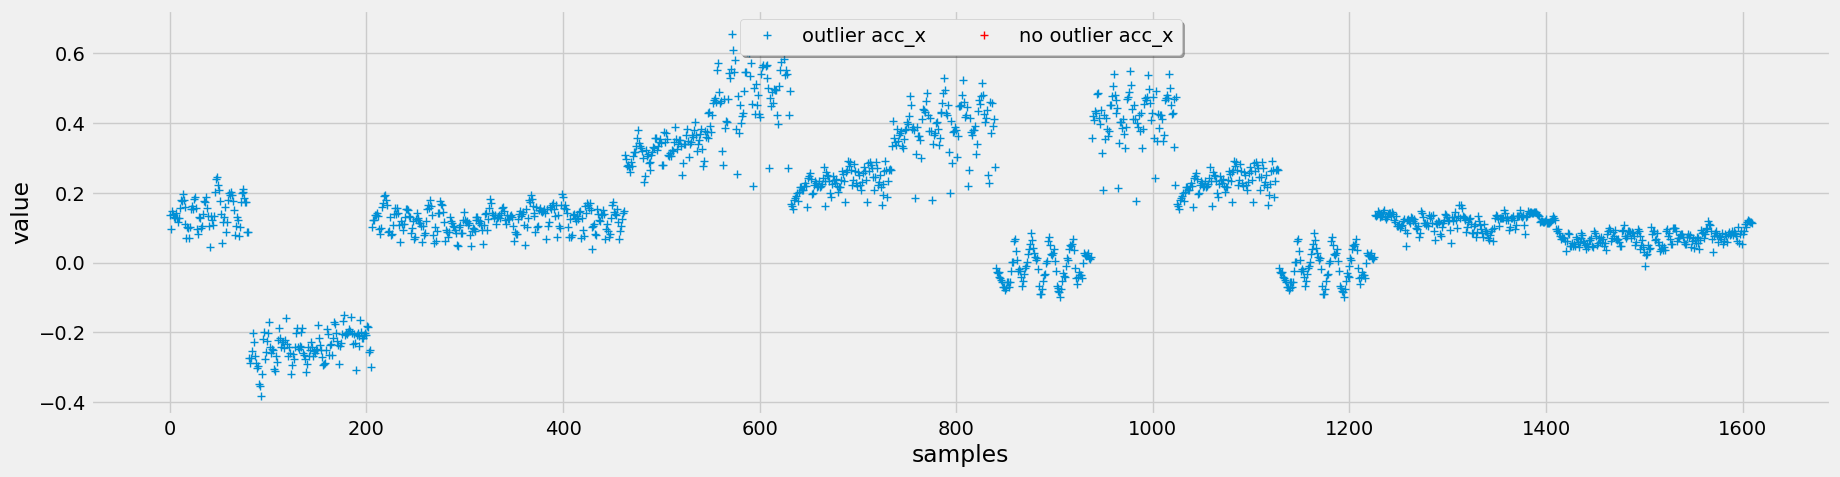

C:\Users\user\AppData\Local\Temp\ipykernel_20216\535511939.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))


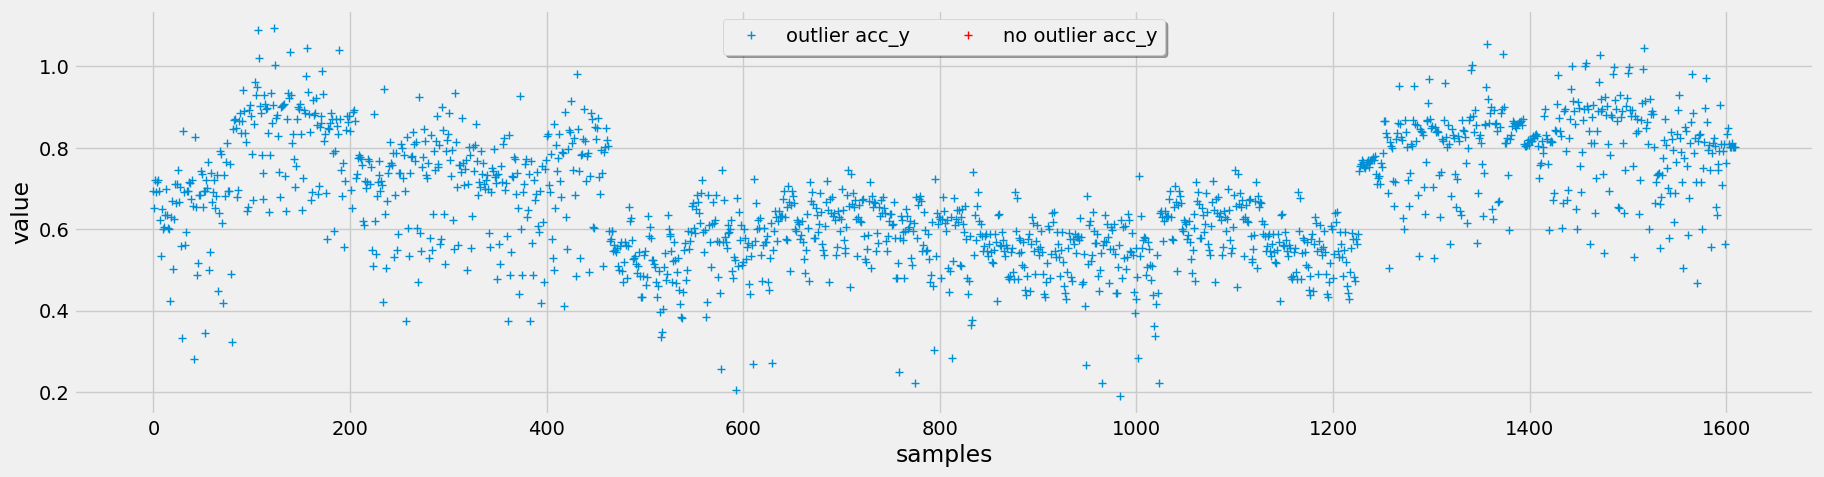

C:\Users\user\AppData\Local\Temp\ipykernel_20216\535511939.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))


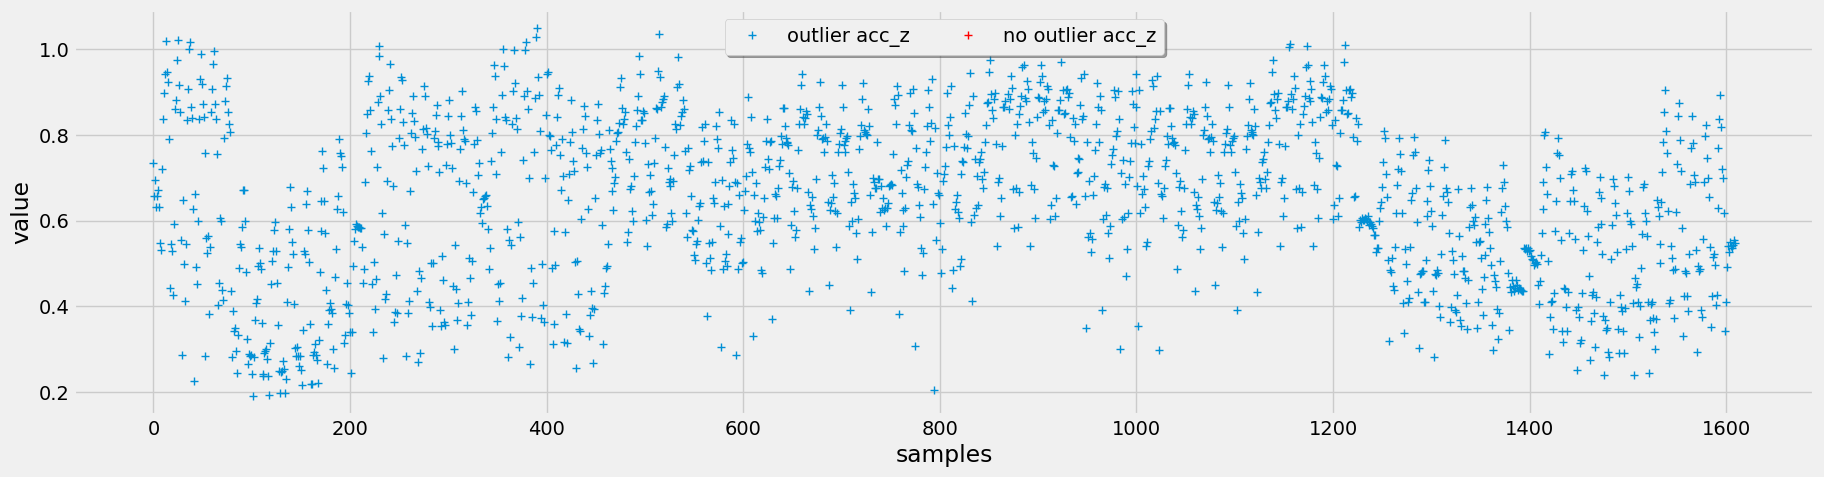

C:\Users\user\AppData\Local\Temp\ipykernel_20216\535511939.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))


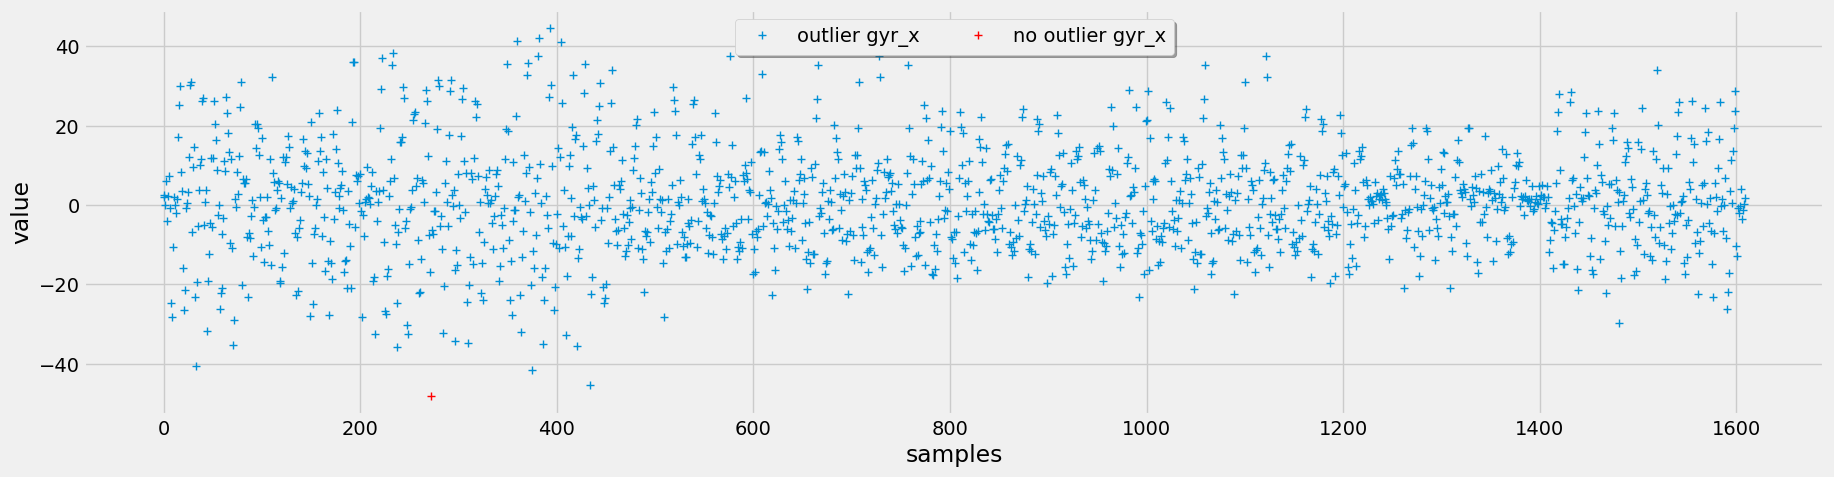

C:\Users\user\AppData\Local\Temp\ipykernel_20216\535511939.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))


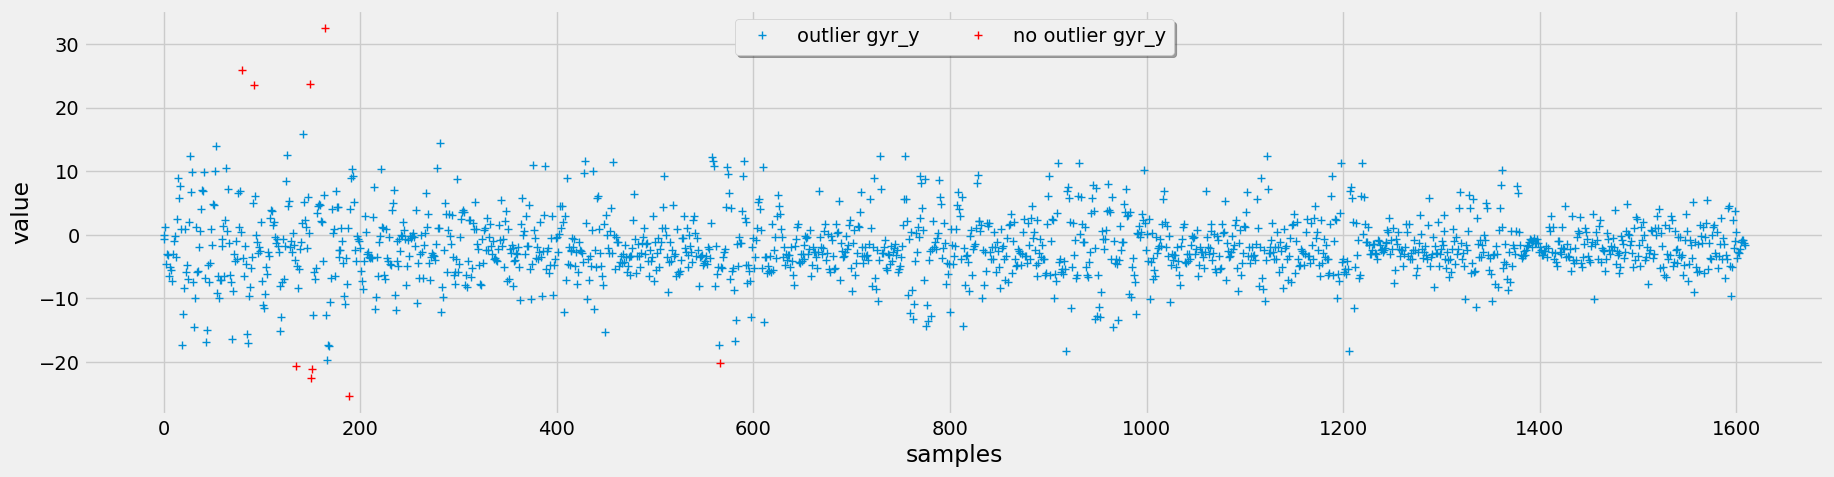

C:\Users\user\AppData\Local\Temp\ipykernel_20216\535511939.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))


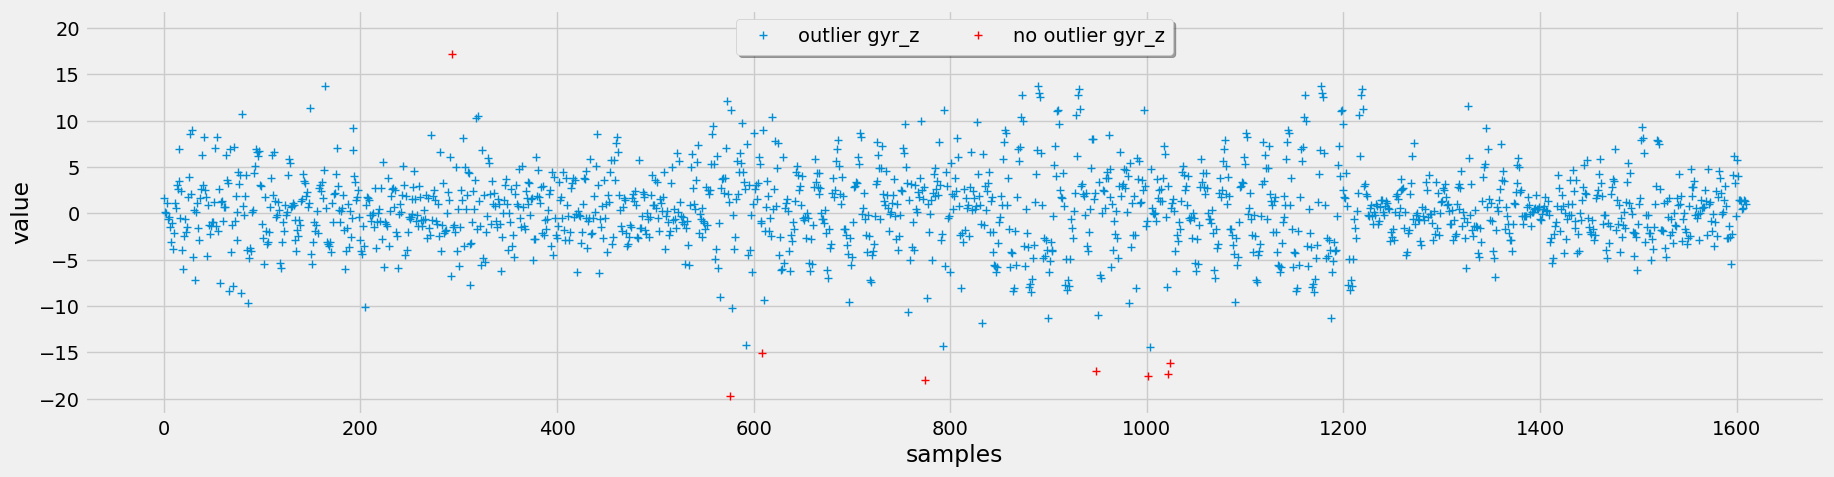

In [217]:
columns = df.columns[:6]
label = 'squat'
for col in columns:
    df_without_outliers = mark_outliers_iqr(df[df['label']== label], col)
    plot_binary_outliers(df_without_outliers, col, col + "_outlier", reset_index=True)
    
for col in columns:
    df_without_outliers = mark_outliers_chauvenet(df[df['label']== label], col)
    plot_binary_outliers(df_without_outliers, col, col + "_outlier", reset_index=True)
    

In [218]:
import scipy.special

In [219]:
outliers_col_name = 'acc_y' 
df_with_outlier_labels = mark_outliers_chauvenet(df, outliers_col_name)


# Drop the 'Value_outlier' column if you no longer need it
#df.drop(columns=[outliers_col_name], inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_20216\535511939.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))


In [220]:
df_with_outlier_labels

acc_x     acc_y     acc_z   gyr_x   gyr_y   gyr_z  \
epoch (ms)                                                                      
2019-01-11 15:08:05.200  0.013500  0.977000 -0.071000 -1.8904  2.4392  0.9388   
2019-01-11 15:08:05.400 -0.001500  0.970500 -0.079500 -1.6826 -0.8904  2.1708   
2019-01-11 15:08:05.600  0.001333  0.971667 -0.064333  2.5608 -0.2560 -1.4146   
2019-01-11 15:08:05.800 -0.024000  0.957000 -0.073500  8.0610 -4.5244 -2.0730   
2019-01-11 15:08:06.000 -0.028000  0.957667 -0.115000  2.4390 -1.5486 -3.6098   
...                           ...       ...       ...     ...     ...     ...   
2019-01-20 17:33:27.000 -0.048000 -1.041500 -0.076500  1.4146 -5.6218  0.2926   
2019-01-20 17:33:27.200 -0.037000 -1.030333 -0.053333 -2.7684 -0.5854  2.2440   
2019-01-20 17:33:27.400 -0.060000 -1.031000 -0.082000  2.8416 -5.1342 -0.1220   
2019-01-20 17:33:27.600 -0.038667 -1.025667 -0.044667 -0.2318  0.2562  1.1220   
2019-01-20 17:33:27.800 -0.044000 -1.034000 -0.059000  1.0980 -4.0240  0.9760   

                        participant  label category  set  acc_y_outlier  
epoch (ms)                                                               
2019-01-11 15:08:05.200           B  bench    heavy   30          False  
2019-01-11 15:08:05.400           B  bench    heavy   30          False  
2019-01-11 15:08:05.600           B  bench    heavy   30          False  
2019-01-11 15:08:05.800           B  bench    heavy   30          False  
2019-01-11 15:08:06.000           B  bench    heavy   30          False  
...                             ...    ...      ...  ...            ...  
2019-01-20 17:33:27.000           E    row   medium   90          False  
2019-01-20 17:33:27.200           E    row   medium   90          False  
2019-01-20 17:33:27.400           E    row   medium   90          False  
2019-01-20 17:33:27.600           E    row   medium   90          False  
2019-01-20 17:33:27.800           E    row   medium   90          False  

[9009 rows x 11 columns]

In [222]:
df_with_outlier_labels.head(100)

acc_x     acc_y     acc_z   gyr_x   gyr_y  \
epoch (ms)                                                              
2019-01-11 15:08:05.200  0.013500  0.977000 -0.071000 -1.8904  2.4392   
2019-01-11 15:08:05.400 -0.001500  0.970500 -0.079500 -1.6826 -0.8904   
2019-01-11 15:08:05.600  0.001333  0.971667 -0.064333  2.5608 -0.2560   
2019-01-11 15:08:05.800 -0.024000  0.957000 -0.073500  8.0610 -4.5244   
2019-01-11 15:08:06.000 -0.028000  0.957667 -0.115000  2.4390 -1.5486   
...                           ...       ...       ...     ...     ...   
2019-01-11 15:10:10.400 -0.131000  0.950667 -0.149667 -2.4024 -0.7804   
2019-01-11 15:10:10.600 -0.099500  0.952500 -0.119500 -8.9388 -0.2806   
2019-01-11 15:10:10.800 -0.027333  0.848000 -0.114333 -9.1950  7.0854   
2019-01-11 15:10:11.000  0.018000  0.925000 -0.117000  9.2436 -7.8782   
2019-01-11 15:10:11.200  0.007667  0.954667 -0.127000  5.2438 -4.1220   

                           gyr_z participant  label category  set  \
epoch (ms)                                                          
2019-01-11 15:08:05.200   0.9388           B  bench    heavy   30   
2019-01-11 15:08:05.400   2.1708           B  bench    heavy   30   
2019-01-11 15:08:05.600  -1.4146           B  bench    heavy   30   
2019-01-11 15:08:05.800  -2.0730           B  bench    heavy   30   
2019-01-11 15:08:06.000  -3.6098           B  bench    heavy   30   
...                          ...         ...    ...      ...  ...   
2019-01-11 15:10:10.400  10.5000           A  bench    heavy    1   
2019-01-11 15:10:10.600  22.1584           A  bench    heavy    1   
2019-01-11 15:10:10.800  22.0854           A  bench    heavy    1   
2019-01-11 15:10:11.000  -3.6340           A  bench    heavy    1   
2019-01-11 15:10:11.200  -5.1950           A  bench    heavy    1   

                         acc_y_outlier  
epoch (ms)                              
2019-01-11 15:08:05.200          False  
2019-01-11 15:08:05.400          False  
2019-01-11 15:08:05.600          False  
2019-01-11 15:08:05.800          False  
2019-01-11 15:08:06.000          False  
...                                ...  
2019-01-11 15:10:10.400          False  
2019-01-11 15:10:10.600          False  
2019-01-11 15:10:10.800          False  
2019-01-11 15:10:11.000          False  
2019-01-11 15:10:11.200          False  

[100 rows x 11 columns]

In [223]:
import pandas as pd

# Assuming you already have your DataFrame with columns 'acc_x' to 'gyr_z' and their corresponding outlier columns
# If not, load your DataFrame or create it first

# List of columns from 'acc_x' to 'gyr_z' for which you have outlier columns
sensor_columns = ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']
df_with_outlier_labels = df.copy()

# Loop through each sensor column and replace values with NaN where the corresponding outlier column is True
for column in sensor_columns:
    df_with_outlier_labels = mark_outliers_chauvenet(df_with_outlier_labels, column)
    df_with_outlier_labels[column] = df_with_outlier_labels.apply(lambda row: float('nan') if row[column +'_outlier'] else row[column], axis=1)




C:\Users\user\AppData\Local\Temp\ipykernel_20216\535511939.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
C:\Users\user\AppData\Local\Temp\ipykernel_20216\535511939.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
C:\Users\user\AppData\Local\Temp\ipykernel_20216\535511939.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a val

In [224]:
df_with_outlier_labels

acc_x     acc_y     acc_z   gyr_x   gyr_y   gyr_z  \
epoch (ms)                                                                      
2019-01-11 15:08:05.200  0.013500  0.977000 -0.071000 -1.8904  2.4392  0.9388   
2019-01-11 15:08:05.400 -0.001500  0.970500 -0.079500 -1.6826 -0.8904  2.1708   
2019-01-11 15:08:05.600  0.001333  0.971667 -0.064333  2.5608 -0.2560 -1.4146   
2019-01-11 15:08:05.800 -0.024000  0.957000 -0.073500  8.0610 -4.5244 -2.0730   
2019-01-11 15:08:06.000 -0.028000  0.957667 -0.115000  2.4390 -1.5486 -3.6098   
...                           ...       ...       ...     ...     ...     ...   
2019-01-20 17:33:27.000 -0.048000 -1.041500 -0.076500  1.4146 -5.6218  0.2926   
2019-01-20 17:33:27.200 -0.037000 -1.030333 -0.053333 -2.7684 -0.5854  2.2440   
2019-01-20 17:33:27.400 -0.060000 -1.031000 -0.082000  2.8416 -5.1342 -0.1220   
2019-01-20 17:33:27.600 -0.038667 -1.025667 -0.044667 -0.2318  0.2562  1.1220   
2019-01-20 17:33:27.800 -0.044000 -1.034000 -0.059000  1.0980 -4.0240  0.9760   

                        participant  label category  set  acc_x_outlier  \
epoch (ms)                                                                
2019-01-11 15:08:05.200           B  bench    heavy   30          False   
2019-01-11 15:08:05.400           B  bench    heavy   30          False   
2019-01-11 15:08:05.600           B  bench    heavy   30          False   
2019-01-11 15:08:05.800           B  bench    heavy   30          False   
2019-01-11 15:08:06.000           B  bench    heavy   30          False   
...                             ...    ...      ...  ...            ...   
2019-01-20 17:33:27.000           E    row   medium   90          False   
2019-01-20 17:33:27.200           E    row   medium   90          False   
2019-01-20 17:33:27.400           E    row   medium   90          False   
2019-01-20 17:33:27.600           E    row   medium   90          False   
2019-01-20 17:33:27.800           E    row   medium   90          False   

                         acc_y_outlier  acc_z_outlier  gyr_x_outlier  \
epoch (ms)                                                             
2019-01-11 15:08:05.200          False          False          False   
2019-01-11 15:08:05.400          False          False          False   
2019-01-11 15:08:05.600          False          False          False   
2019-01-11 15:08:05.800          False          False          False   
2019-01-11 15:08:06.000          False          False          False   
...                                ...            ...            ...   
2019-01-20 17:33:27.000          False          False          False   
2019-01-20 17:33:27.200          False          False          False   
2019-01-20 17:33:27.400          False          False          False   
2019-01-20 17:33:27.600          False          False          False   
2019-01-20 17:33:27.800          False          False          False   

                         gyr_y_outlier  gyr_z_outlier  
epoch (ms)                                             
2019-01-11 15:08:05.200          False          False  
2019-01-11 15:08:05.400          False          False  
2019-01-11 15:08:05.600          False          False  
2019-01-11 15:08:05.800          False          False  
2019-01-11 15:08:06.000          False          False  
...                                ...            ...  
2019-01-20 17:33:27.000          False          False  
2019-01-20 17:33:27.200          False          False  
2019-01-20 17:33:27.400          False          False  
2019-01-20 17:33:27.600          False          False  
2019-01-20 17:33:27.800          False          False  

[9009 rows x 16 columns]

In [225]:
df_with_outlier_labels.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2019-01-11 15:08:05.200000 to 2019-01-20 17:33:27.800000
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   acc_x          8997 non-null   float64
 1   acc_y          9009 non-null   float64
 2   acc_z          9009 non-null   float64
 3   gyr_x          8969 non-null   float64
 4   gyr_y          8885 non-null   float64
 5   gyr_z          8951 non-null   float64
 6   participant    9009 non-null   object 
 7   label          9009 non-null   object 
 8   category       9009 non-null   object 
 9   set            9009 non-null   int32  
 10  acc_x_outlier  9009 non-null   bool   
 11  acc_y_outlier  9009 non-null   bool   
 12  acc_z_outlier  9009 non-null   bool   
 13  gyr_x_outlier  9009 non-null   bool   
 14  gyr_y_outlier  9009 non-null   bool   
 15  gyr_z_outlier  9009 non-null   bool   
dtypes: bool(6), float64(6), int32(1), object(3)
me

In [226]:


# Assuming you have a DataFrame named 'df' with the columns you want to remove

# List of column names to remove
columns_to_remove = ['acc_x_outlier', 'acc_y_outlier', 'acc_z_outlier', 'gyr_x_outlier', 'gyr_y_outlier', 'gyr_z_outlier']

# Use the drop method to remove the specified columns
df_without_outlier = df_with_outlier_labels.drop(columns=columns_to_remove)



In [227]:
df_without_outlier

acc_x     acc_y     acc_z   gyr_x   gyr_y   gyr_z  \
epoch (ms)                                                                      
2019-01-11 15:08:05.200  0.013500  0.977000 -0.071000 -1.8904  2.4392  0.9388   
2019-01-11 15:08:05.400 -0.001500  0.970500 -0.079500 -1.6826 -0.8904  2.1708   
2019-01-11 15:08:05.600  0.001333  0.971667 -0.064333  2.5608 -0.2560 -1.4146   
2019-01-11 15:08:05.800 -0.024000  0.957000 -0.073500  8.0610 -4.5244 -2.0730   
2019-01-11 15:08:06.000 -0.028000  0.957667 -0.115000  2.4390 -1.5486 -3.6098   
...                           ...       ...       ...     ...     ...     ...   
2019-01-20 17:33:27.000 -0.048000 -1.041500 -0.076500  1.4146 -5.6218  0.2926   
2019-01-20 17:33:27.200 -0.037000 -1.030333 -0.053333 -2.7684 -0.5854  2.2440   
2019-01-20 17:33:27.400 -0.060000 -1.031000 -0.082000  2.8416 -5.1342 -0.1220   
2019-01-20 17:33:27.600 -0.038667 -1.025667 -0.044667 -0.2318  0.2562  1.1220   
2019-01-20 17:33:27.800 -0.044000 -1.034000 -0.059000  1.0980 -4.0240  0.9760   

                        participant  label category  set  
epoch (ms)                                                
2019-01-11 15:08:05.200           B  bench    heavy   30  
2019-01-11 15:08:05.400           B  bench    heavy   30  
2019-01-11 15:08:05.600           B  bench    heavy   30  
2019-01-11 15:08:05.800           B  bench    heavy   30  
2019-01-11 15:08:06.000           B  bench    heavy   30  
...                             ...    ...      ...  ...  
2019-01-20 17:33:27.000           E    row   medium   90  
2019-01-20 17:33:27.200           E    row   medium   90  
2019-01-20 17:33:27.400           E    row   medium   90  
2019-01-20 17:33:27.600           E    row   medium   90  
2019-01-20 17:33:27.800           E    row   medium   90  

[9009 rows x 10 columns]

In [228]:
df_without_outlier.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2019-01-11 15:08:05.200000 to 2019-01-20 17:33:27.800000
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   acc_x        8997 non-null   float64
 1   acc_y        9009 non-null   float64
 2   acc_z        9009 non-null   float64
 3   gyr_x        8969 non-null   float64
 4   gyr_y        8885 non-null   float64
 5   gyr_z        8951 non-null   float64
 6   participant  9009 non-null   object 
 7   label        9009 non-null   object 
 8   category     9009 non-null   object 
 9   set          9009 non-null   int32  
dtypes: float64(6), int32(1), object(3)
memory usage: 739.0+ KB


In [229]:
df_without_outlier.to_pickle('D:\\Projects\\AI Fitness Tracker\\data_without_outliers.pkl')


In [230]:
df_without_outlier.to_csv('D:\\Projects\\AI Fitness Tracker\\data_without_outliers.csv')